In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from matplotlib.lines import Line2D
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

In [4]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# Data Collection
___

In [157]:
# Reading the data
coins = pd.read_csv('Coinprices.csv')
nfts = pd.read_csv('NFTprices.csv')
txn_eth = pd.read_csv('EthereumGasFee.csv')
coins = coins.loc[:, ~coins.columns.str.contains('^Unnamed')]
nfts = nfts.loc[:, ~nfts.columns.str.contains('^Unnamed')]

In [158]:
# Basic Pre-processing
coins['Date'] = pd.to_datetime(coins['Date'])
nfts['Date'] = pd.to_datetime(nfts['Date'])
txn_eth['Date'] = pd.to_datetime(txn_eth['Date'])
nfts['NFT'] = nfts['NFT'].str.upper()


pairs = {}
pairing = [['BYTES', 'NEOTOKYO-CITIZENS'], ['CAVE', 'CAVEWORLD'], ['GOB', 'GOONSOFBALATROON'],\
           ['BLOOD', 'IMPOSTORS-GENESIS-ALIENS'], ['APE', 'BORED-APE-YACHT-CLUB']]

# Helper Functions
___

This section contains all the helper function required to execute pair-trading for different strategies.

In [159]:
def combineCoinNft(c, n, coins, nfts):
    tempOne = coins[coins['Symbol'] == c]
    tempTwo = nfts[nfts['NFT'] == n]
    # Inner merge on 'Date' column
    inner_merged = pd.merge(tempOne, tempTwo, on='Date', how='inner')
    inner_merged = inner_merged.rename(columns={'Symbol': 'COIN', 'floorUsd' :'NftPrice', 'Close' :'CoinPrice'})
    inner_merged['Diff'] =  inner_merged['NftPrice'] - inner_merged['CoinPrice']
    return inner_merged

In [160]:
def distance_method_fixed_threshhold_spread(d, formation_window, thresh):
    '''
    This function will perform pair trading for fixed threshold but we will
    focus on spread rather than z-score.
    Parameters:
    d: The dataframe containing the price information
    formation_window: Indicating the number of days on which mean, std is calculated
    thresh: The threshold above or below which the positions will be opened
    '''
    formation_period = d.loc[:formation_window]
    trading_period = d.loc[formation_window + 1:]
    
    formation_mean = formation_period['Diff'].mean()
    formation_std = formation_period['Diff'].std()


    trading_period['spread'] = trading_period['Diff']
    
    trading_mean_spread = trading_period['spread'].mean()
    trading_std_spread = trading_period['spread'].std()
    
    
    upper_threshold = trading_mean_spread + thresh * trading_std_spread
    lower_threshold = trading_mean_spread - thresh * trading_std_spread

    # Identify crossings and add triangles for fixed thresholds (For plotting the graphs)
    fixed_buy_signals = (trading_period['spread'] > upper_threshold) & (trading_period['spread'].shift(1) <= upper_threshold)
    fixed_sell_signals = (trading_period['spread'] < lower_threshold) & (trading_period['spread'].shift(1) >= lower_threshold)

    plot_data = [fixed_buy_signals, fixed_sell_signals, upper_threshold, lower_threshold, trading_mean_spread]

    return trading_period, plot_data

In [161]:
def distance_method_fixed_threshhold(d, formation_window, thresh):
    '''
    This function will perform pair trading for fixed threshold but we will
    focus on z-score rather than spread
    Parameters:
    d: The dataframe containing the price information
    formation_window: Indicating the number of days on which mean, std is calculated
    thresh: The threshold above or below which the positions will be opened
    '''
    formation_period = d.loc[:formation_window]
    trading_period = d.loc[formation_window + 1:]
    
    formation_mean = formation_period['Diff'].mean()
    formation_std = formation_period['Diff'].std()


    trading_period['z'] = (trading_period['Diff'] - formation_mean) / formation_std 
    
    trading_mean_z = trading_period['z'].mean()
    trading_std_z = trading_period['z'].std()
    
    
    upper_threshold = trading_mean_z + thresh * trading_std_z
    lower_threshold = trading_mean_z - thresh * trading_std_z

    # Identify crossings and add triangles for fixed thresholds (For plotting the graphs)
    fixed_buy_signals = (trading_period['z'] > upper_threshold) & (trading_period['z'].shift(1) <= upper_threshold)
    fixed_sell_signals = (trading_period['z'] < lower_threshold) & (trading_period['z'].shift(1) >= lower_threshold)

    plot_data = [fixed_buy_signals, fixed_sell_signals, upper_threshold, lower_threshold, trading_mean_z]

    return trading_period, plot_data

In [162]:
def distance_method_dynmaic_threshold_zscore(df, rolling_window, thresh):
    '''
    This function performs the pair-trading for dynamic threshold but we focus
    on z-score instead of the spread
    Parameters:
    d: The dataframe containing the price information
    formation_window: Indicating the number of days on which mean, std is calculated
    thresh: The threshold above or below which the positions will be opened
    '''
    # Calculate the expanding mean and standard deviation of the difference
    df['Rolling Mean'] = df['Diff'].rolling(window=rolling_window).mean()
    df['Rolling Std'] = df['Diff'].rolling(window=rolling_window).std()
    
    # Calculate the z-score of the difference
    df['z'] = (df['Diff'] - df['Rolling Mean']) / df['Rolling Std']
    
    # Calculate the expanding mean and standard deviation of the z-score
    trading_mean_z = df['z'].expanding().mean()
    trading_std_z = df['z'].expanding().std()
    
    # Define dynamic upper and lower thresholds
    upper_threshold = trading_mean_z + thresh * trading_std_z
    lower_threshold = trading_mean_z - thresh * trading_std_z

    df['Upper Threshhold'] = upper_threshold
    df['Lower Threshhold'] = lower_threshold
    df['Rolling Z'] = trading_mean_z
    
    # Identify crossing points for buy and sell signals
    fixed_buy_signals = (df['z'] > upper_threshold) & (df['z'].shift(1) <= upper_threshold)
    fixed_sell_signals = (df['z'] < lower_threshold) & (df['z'].shift(1) >= lower_threshold)

    plot_data = [fixed_buy_signals, fixed_sell_signals, upper_threshold, lower_threshold, trading_mean_z]
    return df, plot_data

In [163]:
def distance_method_dynamic_threshhold(df, rolling_window, thresh):
    '''
    This function performs the pair-trading for dynamic threshold but we focus
    on spread instead of the z-score.
    Parameters:
    d: The dataframe containing the price information
    formation_window: Indicating the number of days on which mean, std is calculated
    thresh: The threshold above or below which the positions will be opened
    '''
    df['Rolling Mean'] =  df['Diff'].rolling(window=rolling_window).mean()
    df['Rolling Std'] =  df['Diff'].rolling(window=rolling_window).std()

    # Define upper and lower thresholds
    upper_threshold = df['Rolling Mean'] + thresh * df['Rolling Std']
    lower_threshold = df['Rolling Mean'] - thresh * df['Rolling Std']
    rolling_mean = df['Rolling Mean']

    #df = df.dropna()
    
    df['Upper Threshhold'] = upper_threshold
    df['Lower Threshhold'] = lower_threshold
    
    # # # Define upper and lower thresholds
    # upper_threshold = trading_mean_z + 2 * trading_std_z
    # lower_threshold = trading_mean_z - 2 * trading_std_z

    # Identify crossings and add triangles for fixed thresholds
    fixed_buy_signals = (df['Diff'] > upper_threshold) & (df['Diff'].shift(1) <= upper_threshold)
    fixed_sell_signals = (df['Diff'] < lower_threshold) & (df['Diff'].shift(1) >= lower_threshold)

    plot_data = [fixed_buy_signals, fixed_sell_signals, upper_threshold, lower_threshold, rolling_mean]

    return df, plot_data

In [164]:
def distance_method_dynamic_threshhold_stop_loss(df, rolling_window, thresh):
    '''
    This function performs the pair-trading for dynamic threshold but we focus
    on spread instead of the z-score. And we have added stop-loss to prvent big losses
    Parameters:
    d: The dataframe containing the price information
    formation_window: Indicating the number of days on which mean, std is calculated
    thresh: The threshold above or below which the positions will be opened
    '''
    df['Rolling Mean'] =  df['Diff'].rolling(window=rolling_window).mean()
    df['Rolling Std'] =  df['Diff'].rolling(window=rolling_window).std()

    # Define upper and lower thresholds
    upper_threshold = df['Rolling Mean'] + thresh * df['Rolling Std']
    lower_threshold = df['Rolling Mean'] - thresh * df['Rolling Std']
    stop_loss_upper_threshold = df['Rolling Mean'] + (thresh + 1.5) * df['Rolling Std']
    stop_loss_lower_threshold = df['Rolling Mean'] - (thresh + 1.5) * df['Rolling Std']
    rolling_mean = df['Rolling Mean']

    #df = df.dropna()
    
    df['Upper Threshhold'] = upper_threshold
    df['SL Upper Threshhold'] = stop_loss_upper_threshold
    df['Lower Threshhold'] = lower_threshold
    df['SL Lower Threshhold'] = stop_loss_lower_threshold
    
    # # # Define upper and lower thresholds
    # upper_threshold = trading_mean_z + 2 * trading_std_z
    # lower_threshold = trading_mean_z - 2 * trading_std_z

    # Identify crossings and add triangles for fixed thresholds
    fixed_buy_signals = (df['Diff'] > upper_threshold) & (df['Diff'].shift(1) <= upper_threshold)
    fixed_sell_signals = (df['Diff'] < lower_threshold) & (df['Diff'].shift(1) >= lower_threshold)

    plot_data = [fixed_buy_signals, fixed_sell_signals, upper_threshold, lower_threshold, rolling_mean, \
                 stop_loss_upper_threshold, stop_loss_lower_threshold]

    return df, plot_data

In [165]:
def close_positions(open_positions, row, t_history, pair, is_solana):
    '''
    This function will close all the open positions when mean reversion happens.
    The parameters are:
    open_positions: Array containing all the positions that we have taken when thresholds
                    are breached
    row: Contains information about the current price of the coin and the nft
    t_history: dataframe containing all the transaction history
    pair: String containing the nft-coin pair
    is_solana: Boolean which tells us whether the pair is on the solana blockchain 
    '''
    curr_date = row['Date']
    curr_nft = row['NFT']
    curr_coin = row['COIN']
    curr_nft_price = row['NftPrice']
    curr_coin_price = row['CoinPrice']

    curr_txn_info = txn_eth[txn_eth['Date'] == curr_date]

    curr_txn_fee_mean = curr_txn_info['Mean'].iloc[0]
    curr_txn_fee_median = curr_txn_info['Median'].iloc[0]
    curr_txn_fee_25 = curr_txn_info['Percentile_25'].iloc[0]
    curr_txn_fee_75 = curr_txn_info['Percentile_75'].iloc[0]
    
    for o in open_positions:
        o_long = o['Long Asset']
        o_long_price = o['L-Price']

        o_short = o['Short Asset']
        o_short_price = o['S-Price']

        o_l_type = o['L-Type']

        p_l_mean = 0
        p_l_median = 0
        p_l_25 = 0
        p_l_75 = 0

        o_long_close = 0
        o_short_close = 0

        # Capital to open position
        initial_invst = o_long_price + o_short_price
        txn_info = txn_eth[txn_eth['Date'] == o['Date']]

        txn_fee_mean = txn_info['Mean'].iloc[0]
        txn_fee_median = txn_info['Median'].iloc[0] 
        txn_fee_25 = txn_info['Percentile_25'].iloc[0] 
        txn_fee_75 = txn_info['Percentile_75'].iloc[0] 

        initial_invst_mean = initial_invst + 2 * txn_fee_mean
        initial_invst_median = initial_invst + 2 * txn_fee_median
        initial_invst_25 = initial_invst + 2 * txn_fee_25
        initial_invst_75 = initial_invst + 2 * txn_fee_75
        

        if is_solana:
            # The Solana gas fee has more or less been cosntant throughout the years 
            # so I am just taking a constant 
            # value for that
            txn_fee_mean, txn_fee_median, txn_fee_25, txn_fee_75, \
            curr_txn_fee_mean, curr_txn_fee_median, curr_txn_fee_25, curr_txn_fee_75 = [0.002] * 8

        if (o_l_type == 'C'):
            # Spread was over-priced. We longed the coin
            p_l_mean = (curr_coin_price - o_long_price) + (o_short_price - curr_nft_price) \
                       - 2 * (txn_fee_mean + curr_txn_fee_mean)
            p_l_median = (curr_coin_price - o_long_price) + (o_short_price - curr_nft_price) \
                       - 2 * (txn_fee_median + curr_txn_fee_median)
            p_l_25= (curr_coin_price - o_long_price) + (o_short_price - curr_nft_price) \
                     - 2 * (txn_fee_25 + curr_txn_fee_25)
            p_l_75 = (curr_coin_price - o_long_price) + (o_short_price - curr_nft_price) \
                     - 2 * (txn_fee_75 + curr_txn_fee_75)
            
            o_long_close = curr_coin_price
            o_short_close = curr_nft_price

            p_l_mean = p_l_mean / initial_invst_mean
            p_l_median = p_l_median / initial_invst_median
            p_l_25 = p_l_25 / initial_invst_25
            p_l_75 = p_l_75 / initial_invst_75
        else:
            # Spread was under-priced. We shorted the coin
            p_l_mean = (curr_nft_price - o_long_price) + (o_short_price - curr_coin_price)\
                       - 2 *(txn_fee_mean + curr_txn_fee_mean)
            p_l_median = (curr_nft_price - o_long_price) + (o_short_price - curr_coin_price) \
                         - 2 *(txn_fee_median + curr_txn_fee_median)
            p_l_25 = (curr_nft_price - o_long_price) + (o_short_price - curr_coin_price) \
                     - 2 *(txn_fee_25 + curr_txn_fee_25)
            p_l_75 = (curr_nft_price - o_long_price) + (o_short_price - curr_coin_price) \
                     - 2 *(txn_fee_75 + curr_txn_fee_75)
            
            o_long_close = curr_nft_price
            o_short_close = curr_coin_price

            p_l_mean = p_l_mean / initial_invst_mean
            p_l_median = p_l_median / initial_invst_median
            p_l_25 = p_l_25 / initial_invst_25
            p_l_75 = p_l_75 / initial_invst_75

        transaction = {'Date': curr_date,'Pair' : pair, 'Type of Transaction' : 'CLOSE', 'ID' : o['ID'],\
                       'L-Type': 'N/A', 'Long Asset': o_long, 'L-Price': o_long_price, \
                       'Close L-Price': o_long_close, 'Short Asset' : o_short, 'S-Price': o_short_price,\
                       'Close S-Price': o_short_close, \
                       'P/L (Mean Txn Fee)' : p_l_mean, \
                       'P/L (25% Percentile Txn Fee)': p_l_25,  \
                       'P/L (75% Percentile Txn Fee)': p_l_75,  \
                       'P/L (50% Percentile Txn Fee)': p_l_median}
    
        t_history.loc[len(t_history.index)] = transaction

    # close all the positons by emptying the list
    open_positions.clear()

In [166]:
def execute_pair_trading_fixed_dm(pt, pt_plot, transactions_history, pair, is_solana):
    '''
    Parameters:
    pt: contains prices of coin-nft pair 
    pt_plot: Contains threshold and mean information
    transactions_history: dataframe containing all the transaction history
    pair: String containing the nft-coin pair
    is_solana: Boolean which tells us whether the pair is on the solana blockchain 

    This function executes the pair-trading for fixed-threshold. We will use Z-Score for this.
    We traverse throw all the dates one by one, If the Z-score crosses the thresh-hold 
    then we open a long/short position 
    We then close it when it crosses the mean

    There can be three cases which we need to look at:
        Case 1: Z-score crosses upper thresh-hold: In this case we open position consisting of: 
                selling coin i (short) and buying coin j(long)
        Case 2: Z-score crosses lower thresh-hold: 
                In this case we open position consisting of: buying coin i (long) and selling coin j(short)
        Case 3: Z-score crosses the mean. In this case we close all the existing positions and take 
                profits/loss. This however can happen from both directions
    '''
    
    # to keep track of the open positions
    open_positions = []
    upper_thresh = pt_plot[2]
    lower_thresh = pt_plot[3]
    mean = pt_plot[4]
    first_row_date = pt.iloc[0]
    prev_z = first_row_date['z']
    i = 0
    
    for index, row in pt.iloc[1:].iterrows():
        curr_z = row['z']
        curr_date = row['Date']
        curr_nft = row['NFT']
        curr_coin = row['COIN']
        curr_nft_price = row['NftPrice']
        curr_coin_price = row['CoinPrice']
    
        if ((curr_z > mean and prev_z <= mean) \
            or (curr_z < mean and prev_z >= mean)) and (len(open_positions) != 0):
            # the spread has come back to the mean. It is time to close all the positions
            close_positions(open_positions, row, transactions_history, pair, is_solana)
        
        if (curr_z > upper_thresh and prev_z <= upper_thresh):
            # Spread is over-priced
            transaction = {'Date': curr_date, 'Pair' : pair,'Type of Transaction' : 'SHORT', 'ID' : i,\
                           'L-Type': 'C', 'Long Asset': curr_coin, 'L-Price': curr_coin_price, \
                           'Short Asset' : curr_nft, 'S-Price': curr_nft_price, 'P/L': 0}
            i = i + 1
            open_positions.append(transaction)
            transactions_history.loc[len(transactions_history.index)] = transaction
        elif (curr_z < lower_thresh and prev_z >= lower_thresh):
            # Spread is under-priced
            transaction = {'Date': curr_date, 'Pair' : pair, 'Type of Transaction' : 'LONG', 'ID' : i, \
                           'L-Type': 'N','Long Asset': curr_nft, 'L-Price': curr_nft_price, \
                           'Short Asset' : curr_coin, 'S-Price': curr_coin_price, 'P/L': 0}
            i = i + 1
            open_positions.append(transaction)
            transactions_history.loc[len(transactions_history.index)] = transaction
    
        prev_z = curr_z

In [167]:
def execute_pair_trading_fixed_dm_spread(pt, pt_plot, transactions_history, pair, is_solana):
    '''
    Parameters:
    pt: contains prices of coin-nft pair 
    pt_plot: Contains threshold and mean information
    transactions_history: dataframe containing all the transaction history
    pair: String containing the nft-coin pair
    is_solana: Boolean which tells us whether the pair is on the solana blockchain 

    This function executes the pair-trading for fixed-threshold. We will use spread for this.
    We traverse throw all the dates one by one, If the spread crosses the thresh-hold 
    then we open a long/short position 
    We then close it when it crosses the mean

    There can be three cases which we need to look at:
        Case 1: Spread crosses upper thresh-hold: In this case we open position consisting of: 
                selling coin i (short) and buying coin j(long)
        Case 2: Spread crosses lower thresh-hold: 
                In this case we open position consisting of: buying coin i (long) and selling coin j(short)
        Case 3: Spread crosses the mean. In this case we close all the existing positions and take 
                profits/loss. This however can happen from both directions
    '''
    
    # to keep track of the open positions
    open_positions = []
    upper_thresh = pt_plot[2]
    lower_thresh = pt_plot[3]
    mean = pt_plot[4]
    first_row_date = pt.iloc[0]
    prev_z = first_row_date['spread']
    i = 0
    
    for index, row in pt.iloc[1:].iterrows():
        curr_z = row['spread']
        curr_date = row['Date']
        curr_nft = row['NFT']
        curr_coin = row['COIN']
        curr_nft_price = row['NftPrice']
        curr_coin_price = row['CoinPrice']
        
        if ((curr_z > mean and prev_z <= mean) \
            or (curr_z < mean and prev_z >= mean)) and (len(open_positions) != 0):
            # the spread has come back to the mean. It is time to close all the positions
            close_positions(open_positions, row, transactions_history, pair, is_solana)
        
        if (curr_z > upper_thresh and prev_z <= upper_thresh):
            # Spread is over-priced
            transaction = {'Date': curr_date, 'Pair' : pair,'Type of Transaction' : 'SHORT', 'ID' : i, \
                           'L-Type': 'C', 'Long Asset': curr_coin, 'L-Price': curr_coin_price, \
                           'Short Asset' : curr_nft, 'S-Price': curr_nft_price, 'P/L': 0}
            i = i + 1
            open_positions.append(transaction)
            transactions_history.loc[len(transactions_history.index)] = transaction
        elif (curr_z < lower_thresh and prev_z >= lower_thresh):
            # Spread is under-priced
            transaction = {'Date': curr_date, 'Pair' : pair, 'Type of Transaction' : 'LONG', 'ID' : i, \
                           'L-Type': 'N','Long Asset': curr_nft, 'L-Price': curr_nft_price, \
                           'Short Asset' : curr_coin, 'S-Price': curr_coin_price, 'P/L': 0}
            i = i + 1
            open_positions.append(transaction)
            transactions_history.loc[len(transactions_history.index)] = transaction
    
        prev_z = curr_z

In [168]:
def execute_pair_trading_dynamic_dm_zscore(pt, pt_plot, transactions_history_dynamic, pair, is_solana):
    '''
    Parameters:
    pt: contains prices of coin-nft pair 
    pt_plot: Contains threshold and mean information
    transactions_history: dataframe containing all the transaction history
    pair: String containing the nft-coin pair
    is_solana: Boolean which tells us whether the pair is on the solana blockchain 

    This function executes the pair-trading for dynamic-threshold. We will use Z-Score for this.
    We traverse throw all the dates one by one, If the Z-score crosses the thresh-hold 
    then we open a long/short position 
    We then close it when it crosses the mean

    There can be three cases which we need to look at:
        Case 1: Z-score crosses upper thresh-hold: In this case we open position consisting of: 
                selling coin i (short) and buying coin j(long)
        Case 2: Z-score crosses lower thresh-hold: 
                In this case we open position consisting of: buying coin i (long) and selling coin j(short)
        Case 3: Z-score crosses the mean. In this case we close all the existing positions and take 
                profits/loss. This however can happen from both directions
    '''
    # to keep track of the open positions
    open_positions = []
    dynamic_upper_thresh = pt_plot[2]
    dynamic_lower_thresh = pt_plot[3]
    dynamic_mean = pt_plot[4]
    first_row_date = pt.iloc[0]
    prev_spread = first_row_date['z']
    i = 0
    for index, row in pt.iloc[1:].iterrows():
        curr_spread = row['z']
        curr_date = row['Date']
        curr_nft = row['NFT']
        curr_coin = row['COIN']
        curr_nft_price = row['NftPrice']
        curr_coin_price = row['CoinPrice']
        current_upper = row['Upper Threshhold']
        current_lower = row['Lower Threshhold']
        current_mean = row['Rolling Z']
        
        if ((curr_spread > current_mean and prev_spread <= current_mean) or \
            (curr_spread < current_mean and prev_spread >= current_mean)) and (len(open_positions) != 0):
            # the spread has come back to the mean. It is time to close all the positions
            #print('Here', open_positions)
            close_positions(open_positions, row, transactions_history_dynamic, pair, is_solana)
        
        if (curr_spread > current_upper and prev_spread <= current_upper):
            # Spread is over-priced
            transaction = {'Date': curr_date, 'Pair' : pair,'Type of Transaction' : 'SHORT', 'ID' : i,\
                           'L-Type': 'C', 'Long Asset': curr_coin, 'L-Price': curr_coin_price, \
                           'Short Asset' : curr_nft, 'S-Price': curr_nft_price, 'P/L': 0}
            i = i + 1
            open_positions.append(transaction)
            transactions_history_dynamic.loc[len(transactions_history_dynamic.index)] = transaction
        elif (curr_spread < current_lower and prev_spread >= current_lower):
            # Spread is under-priced
            transaction = {'Date': curr_date, 'Pair' : pair,'Type of Transaction' : 'LONG', 'ID' : i, \
                           'L-Type': 'N','Long Asset': curr_nft, 'L-Price': curr_nft_price, \
                           'Short Asset' : curr_coin, 'S-Price': curr_coin_price, 'P/L': 0}
            i = i + 1
            open_positions.append(transaction)
            transactions_history_dynamic.loc[len(transactions_history_dynamic.index)] = transaction
    
        prev_spread = curr_spread

In [169]:
def execute_pair_trading_dynamic_dm(pt, pt_plot, transactions_history_dynamic, pair, is_solana):
    '''
    Parameters:
    pt: contains prices of coin-nft pair 
    pt_plot: Contains threshold and mean information
    transactions_history: dataframe containing all the transaction history
    pair: String containing the nft-coin pair
    is_solana: Boolean which tells us whether the pair is on the solana blockchain 

    This function executes the pair-trading for dynamic-threshold. We will use spread for this.
    We traverse throw all the dates one by one, If the spread crosses the thresh-hold 
    then we open a long/short position 
    We then close it when it crosses the mean

    There can be three cases which we need to look at:
        Case 1: Spread crosses upper thresh-hold: In this case we open position consisting of: 
                selling coin i (short) and buying coin j(long)
        Case 2: Spread crosses lower thresh-hold: 
                In this case we open position consisting of: buying coin i (long) and selling coin j(short)
        Case 3: Spread crosses the mean. In this case we close all the existing positions and 
                take profits/loss. This however can happen from both directions
    '''
    # to keep track of the open positions
    open_positions = []
    dynamic_upper_thresh = pt_plot[2]
    dynamic_lower_thresh = pt_plot[3]
    dynamic_mean = pt_plot[4]
    first_row_date = pt.iloc[0]
    prev_spread = first_row_date['Diff']
    i = 0
    for index, row in pt.iloc[1:].iterrows():
        curr_spread = row['Diff']
        curr_date = row['Date']
        curr_nft = row['NFT']
        curr_coin = row['COIN']
        curr_nft_price = row['NftPrice']
        curr_coin_price = row['CoinPrice']
        current_upper = row['Upper Threshhold']
        current_lower = row['Lower Threshhold']
        current_mean = row['Rolling Mean']
        
        if ((curr_spread > current_mean and prev_spread <= current_mean) or \
            (curr_spread < current_mean and prev_spread >= current_mean)) and (len(open_positions) != 0):
            # the spread has come back to the mean. It is time to close all the positions
            #print('Here', open_positions)
            close_positions(open_positions, row, transactions_history_dynamic, pair, is_solana)
        
        if (curr_spread > current_upper and prev_spread <= current_upper):
            # Spread is over-priced
            transaction = {'Date': curr_date, 'Pair' : pair,'Type of Transaction' : 'SHORT', 'ID' : i,\
                           'L-Type': 'C', 'Long Asset': curr_coin, 'L-Price': curr_coin_price, \
                           'Short Asset' : curr_nft, 'S-Price': curr_nft_price, 'P/L': 0}
            i = i + 1
            open_positions.append(transaction)
            transactions_history_dynamic.loc[len(transactions_history_dynamic.index)] = transaction
        elif (curr_spread < current_lower and prev_spread >= current_lower):
            # Spread is under-priced
            transaction = {'Date': curr_date, 'Pair' : pair,'Type of Transaction' : 'LONG', 'ID' : i, \
                           'L-Type': 'N','Long Asset': curr_nft, 'L-Price': curr_nft_price, \
                           'Short Asset' : curr_coin, 'S-Price': curr_coin_price, 'P/L': 0}
            i = i + 1
            open_positions.append(transaction)
            transactions_history_dynamic.loc[len(transactions_history_dynamic.index)] = transaction
    
        prev_spread = curr_spread

In [170]:
def execute_pair_trading_dynamic_dm_stop_loss(pt, pt_plot, transactions_history_dynamic, pair, is_solana):
    '''
    Parameters:
    pt: contains prices of coin-nft pair 
    pt_plot: Contains threshold and mean information
    transactions_history: dataframe containing all the transaction history
    pair: String containing the nft-coin pair
    is_solana: Boolean which tells us whether the pair is on the solana blockchain 

    This function executes the pair-trading for dynamic-threshold. We will use spread for this.
    We traverse throw all the dates one by one, If the spread crosses the thresh-hold 
    then we open a long/short position 
    We then close it when it crosses the mean

    There can be three cases which we need to look at:
        Case 1: Spread crosses upper thresh-hold: In this case we open position consisting of: 
                selling coin i (short) and buying coin j(long)
        Case 2: Spread crosses lower thresh-hold: 
                In this case we open position consisting of: buying coin i (long) and selling coin j(short)
        Case 3: Spread crosses the mean. In this case we close all the existing positions and take 
                profits/loss. This however can happen from both directions

    There is one more case where positions positions will be closed when we exceed a certain threshold above
    the thresholds we have already defined.
    '''
    # to keep track of the open positions
    open_positions = []
    dynamic_upper_thresh = pt_plot[2]
    dynamic_lower_thresh = pt_plot[3]
    stop_loss_upper_thresh = pt_plot[5]
    stop_loss_lower_thresh = pt_plot[6]
    dynamic_mean = pt_plot[4]
    first_row_date = pt.iloc[0]
    prev_spread = first_row_date['Diff']
    i = 0
    for index, row in pt.iloc[1:].iterrows():
        curr_spread = row['Diff']
        curr_date = row['Date']
        curr_nft = row['NFT']
        curr_coin = row['COIN']
        curr_nft_price = row['NftPrice']
        curr_coin_price = row['CoinPrice']
        current_upper = row['Upper Threshhold']
        current_upper_sl = row['SL Upper Threshhold']
        current_lower = row['Lower Threshhold']
        current_lower_sl = row['SL Lower Threshhold']
        current_mean = row['Rolling Mean']
        
        if ((curr_spread > current_mean and prev_spread <= current_mean) or \
            (curr_spread < current_mean and prev_spread >= current_mean)) and (len(open_positions) != 0):
            # the spread has come back to the mean. It is time to close all the positions
            close_positions(open_positions, row, transactions_history_dynamic, pair, is_solana)

        '''
            It is time to look if any stop losses got triggered or not. For this unfortunately we will 
            have to go through all open positions one by one. This will definitely have an impact 
            on the strategy execution time

            We also need to set a threshold for the stop loss that would be triggered. Normally in a 
            pair-trading strategy when a stop loss is placed, the logic that is followed is that when 
            the spread of an open position goes above a certain thresh-hold, the positions are closed
        '''
        sl_positions = []
        for o in open_positions:
            open_spread_upper = o['SL Upper']
            open_spread_lower = o['SL Lower']
            if (curr_spread > open_spread_upper and prev_spread <= open_spread_upper):
                # stop-loss has been hit for upper threshold
                sl_positions.append(o)
            elif (curr_spread < open_spread_lower and prev_spread >= open_spread_lower):
                # stop-loss has been hit for lower threshold
                sl_positions.append(o)

        open_positions_t = [o for o in open_positions if o not in sl_positions]
        open_positions = open_positions_t
        
        if len(sl_positions) > 0:
            close_positions(sl_positions, row, transactions_history_dynamic, pair, is_solana)
        
        if (curr_spread > current_upper and prev_spread <= current_upper):
            # Spread is over-priced
            transaction = {'Date': curr_date, 'Pair' : pair,'Type of Transaction' : 'SHORT',\
                           'ID' : i, 'L-Type': 'C', 'Long Asset': curr_coin, 'L-Price': curr_coin_price, \
                           'Short Asset' : curr_nft, 'S-Price': curr_nft_price, 'P/L': 0,\
                           'Spread': curr_spread,\
                           'SL Upper': current_upper_sl, 'SL Lower': current_lower_sl}
            i = i + 1
            open_positions.append(transaction)
            transactions_history_dynamic.loc[len(transactions_history_dynamic.index)] = transaction
        elif (curr_spread < current_lower and prev_spread >= current_lower):
            # Spread is under-priced
            transaction = {'Date': curr_date, 'Pair' : pair,'Type of Transaction' : 'LONG', 'ID' : i, \
                           'L-Type': 'N', 'Long Asset': curr_nft, 'L-Price': curr_nft_price, \
                           'Short Asset' : curr_coin, 'S-Price': curr_coin_price,'P/L': 0, \
                           'Spread': curr_spread, 'SL Upper': current_upper_sl, 'SL Lower': current_lower_sl}
            i = i + 1
            open_positions.append(transaction)
            transactions_history_dynamic.loc[len(transactions_history_dynamic.index)] = transaction
    
        prev_spread = curr_spread

In [171]:
def execute_pair_trading_benchmark_dm(pt, pt_plot, transactions_history_dynamic, pair, is_solana):
    '''
    Parameters:
    pt: contains prices of coin-nft pair 
    pt_plot: Contains threshold and mean information
    transactions_history: dataframe containing all the transaction history
    pair: String containing the nft-coin pair
    is_solana: Boolean which tells us whether the pair is on the solana blockchain 

    This function executes the pair-trading for buy-hold. We will use spread for this.
    We traverse throw all the dates one by one, If the spread crosses the thresh-hold 
    then we open a long/short position 
    We then close it when it crosses the mean

    There can be two cases which we need to look at:
        Case 1: Spread crosses upper thresh-hold: In this case we open position consisting of: 
                selling coin i (short) and buying coin j(long)
        Case 2: Spread crosses lower thresh-hold: 
                In this case we open position consisting of: buying coin i (long) and selling coin j(short)
    We will only close positions at the end of the trading time period.
    '''
    # to keep track of the open positions
    open_positions = []
    dynamic_upper_thresh = pt_plot[2]
    dynamic_lower_thresh = pt_plot[3]
    dynamic_mean = pt_plot[4]
    first_row_date = pt.iloc[0]
    prev_spread = first_row_date['Diff']
    i = 0
    lastRow = None
    for index, row in pt.iloc[1:].iterrows():
        curr_spread = row['Diff']
        curr_date = row['Date']
        curr_nft = row['NFT']
        curr_coin = row['COIN']
        curr_nft_price = row['NftPrice']
        curr_coin_price = row['CoinPrice']
        current_upper = row['Upper Threshhold']
        current_lower = row['Lower Threshhold']
        current_mean = row['Rolling Mean']
        if (curr_spread > current_upper and prev_spread <= current_upper):
            # Spread is over-priced
            transaction = {'Date': curr_date, 'Pair' : pair,'Type of Transaction' : 'SHORT', 'ID' : i,\
                           'L-Type': 'C', 'Long Asset': curr_coin, 'L-Price': curr_coin_price, \
                           'Short Asset' : curr_nft, 'S-Price': curr_nft_price, 'P/L': 0}
            i = i + 1
            open_positions.append(transaction)
            transactions_history_dynamic.loc[len(transactions_history_dynamic.index)] = transaction
        elif (curr_spread < current_lower and prev_spread >= current_lower):
            # Spread is under-priced
            transaction = {'Date': curr_date, 'Pair' : pair,'Type of Transaction' : 'LONG', 'ID' : i,\
                           'L-Type': 'N','Long Asset': curr_nft, 'L-Price': curr_nft_price, \
                           'Short Asset' : curr_coin, 'S-Price': curr_coin_price, 'P/L': 0}
            i = i + 1
            open_positions.append(transaction)
            transactions_history_dynamic.loc[len(transactions_history_dynamic.index)] = transaction
    
        prev_spread = curr_spread
        lastRow = row
    close_positions(open_positions, row, transactions_history_dynamic, pair, is_solana)

In [172]:
def get_sharpe_ratio(df, risk_free_rate):
    '''
        Function to calculate the sharpe ratio
    '''
    returns = df['P/L (Mean Txn Fee)']
    excess_returns = returns - risk_free_rate
    avg_excess_return = excess_returns.mean()
    std_excess_return = excess_returns.std()
    if std_excess_return == 0:
        return np.nan  # Avoid division by zero
    return avg_excess_return / std_excess_return

In [173]:
def get_summary_stats_pl(df):
    '''
        Function to calculate aggregated stats
    '''
    sharpe = get_sharpe_ratio(df, 0.04)
    result = df[df['Type of Transaction'] == 'CLOSE'].groupby('Pair').agg(
        Count=pd.NamedAgg(column='P/L (25% Percentile Txn Fee)', aggfunc='count'),  # Using the same column to count entries
        Total_Return_Mean=pd.NamedAgg(column='P/L (25% Percentile Txn Fee)', aggfunc='sum'),
        Max_Return_Mean=pd.NamedAgg(column='P/L (25% Percentile Txn Fee)', aggfunc='max'),
        Min_Return_Mean=pd.NamedAgg(column='P/L (25% Percentile Txn Fee)', aggfunc='min'),
        Avg_Return_Mean=pd.NamedAgg(column='P/L (25% Percentile Txn Fee)', aggfunc='mean'),
        
        Total_Return_Median=pd.NamedAgg(column='P/L (50% Percentile Txn Fee)', aggfunc='sum'),
        Max_Return_Median=pd.NamedAgg(column='P/L (50% Percentile Txn Fee)', aggfunc='max'),
        Min_Return_Median=pd.NamedAgg(column='P/L (50% Percentile Txn Fee)', aggfunc='min'),
        Avg_Return_Median=pd.NamedAgg(column='P/L (50% Percentile Txn Fee)', aggfunc='mean'),
        
        Total_Return_25=pd.NamedAgg(column='P/L (75% Percentile Txn Fee)', aggfunc='sum'),
        Max_Return_25=pd.NamedAgg(column='P/L (75% Percentile Txn Fee)', aggfunc='max'),
        Min_Return_25=pd.NamedAgg(column='P/L (75% Percentile Txn Fee)', aggfunc='min'),
        Avg_Return_25=pd.NamedAgg(column='P/L (75% Percentile Txn Fee)', aggfunc='mean'),
        
        Total_Return_75=pd.NamedAgg(column='P/L (Mean Txn Fee)', aggfunc='sum'),
        Max_Return_75=pd.NamedAgg(column='P/L (Mean Txn Fee)', aggfunc='max'),
        Min_Return_75=pd.NamedAgg(column='P/L (Mean Txn Fee)', aggfunc='min'),
        Avg_Return_75=pd.NamedAgg(column='P/L (Mean Txn Fee)', aggfunc='mean'),

    )
    #result['Average Return'] = result['Total_Return']/ result['Count']
    return result, sharpe

In [174]:
def plot_metric(ax, metric, title, data):
    '''
        Helper function to plot each metric
    '''
    lines = []  # To hold the line objects for the legend
    for threshold, group in data.groupby(level=0):
        line, = ax.plot(group.index.get_level_values(1), group[metric], marker='o',\
                        label=f'Threshold {threshold}')
        lines.append(line)
    ax.set_title(title)
    ax.set_xlabel('Rolling Period')
    ax.set_ylabel(metric)
    ax.grid(True)
    return lines

In [175]:
def plot_diff_graphs(df, benchmark = True):
    '''
        This is a helper function to show the different kinds of plots.
        The main aim of this function is to reduce code redundancy
    '''
    # Create plots
    fig, axes = plt.subplots(3, 2, figsize=(12, 15))  # 3 rows, 2 columns layout
    # Plotting each return
    lines = plot_metric(axes[0, 0], 'Return (25% Percentile Txn Fee)',\
                        'Return (P/L) at 25% Percentile Txn Fee', df)
    plot_metric(axes[0, 1], 'Return (50% Percentile Txn Fee)', 'Return (P/L)at 50% Percentile Txn Fee',df)
    plot_metric(axes[1, 0], 'Return (75% Percentile Txn Fee)', 'Return(P/L) at 75% Percentile Txn Fee',df)
    plot_metric(axes[1, 1], 'Return (Mean Txn Fee)', 'Return(P/L) (Mean Txn Fee)',df)
    if benchmark:
        plot_metric(axes[2, 0], 'Avg No. of Trades', 'Avg No. of Trades',df)
    
    # Place a single legend outside the plots
    fig.legend(handles=lines, loc='lower center', ncol=len(df.index.get_level_values(0).unique()), \
               bbox_to_anchor=(0.5, 0.05))
    
    
    # Remove empty subplot (if needed)
    fig.delaxes(axes[2, 1])
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()

____________

In [176]:
# creating seperate dataframes for nft-coin pair
pairing_keys = []
for p in pairing:
    key = p[0] + '-' + p[1]
    print(key)
    pairing_keys.append(key)
    coinNftPrice = combineCoinNft(p[0], p[1], coins, nfts)
    pairs[key] = coinNftPrice

BYTES-NEOTOKYO-CITIZENS
CAVE-CAVEWORLD
GOB-GOONSOFBALATROON
BLOOD-IMPOSTORS-GENESIS-ALIENS
APE-BORED-APE-YACHT-CLUB


In [177]:
rolling_period = [30, 45, 60, 75, 90, 120]
#rolling_period = [60]
thresholds = [0.5, 1, 1.5, 2, 2.5]
#thresholds = [ 2]

# Fixed Threshold: Z-Score
___

In [178]:
fixed_th_ds_pl = pd.DataFrame(columns=['Threshold (Fixed)','Rolling Period', 'Avg No. of Trades', \
                                    'Return (25% Percentile Txn Fee)', 'Max Return (25% Percentile Txn Fee)', 'Min Return (25% Percentile Txn Fee)', \
                                    'Return (50% Percentile Txn Fee)', 'Max Return (50% Percentile Txn Fee)', 'Min Return (50% Percentile Txn Fee)', \
                                    'Return (75% Percentile Txn Fee)', 'Max Return (75% Percentile Txn Fee)', 'Min Return (75% Percentile Txn Fee)', \
                                    'Return (Mean Txn Fee)', 'Max Return (Mean Txn Fee)', 'Min Return (Mean Txn Fee)', 'Sharpe Ratio'])
temp = None
for t in thresholds:
    for r in rolling_period:
        transactions_history = pd.DataFrame(columns=['Date', 'Pair', 'Type of Transaction', 'ID', \
                                                     'L-Type', 'Long Asset', 'L-Price', 'Close L-Price',\
                                                     'Short Asset', 'S-Price','Close S-Price',   \
                                                     'P/L (25% Percentile Txn Fee)', 'P/L (Mean Txn Fee)', 'P/L (50% Percentile Txn Fee)',\
                                                     'P/L (75% Percentile Txn Fee)'])
        for p in pairing_keys:
            is_solana = False
            if(p == 'CAVE-CAVEWORLD'): 
                # We only have one nft-coin pair on the solana block-chain
                is_solana = True
            df = pairs[p]
            fixed_dm_df, fixed_dm_plot = distance_method_fixed_threshhold(df, r, t)
            execute_pair_trading_fixed_dm(fixed_dm_df, fixed_dm_plot, transactions_history, p, is_solana)
            
        result, sharpe = get_summary_stats_pl(transactions_history)
        rolling_window_stats_pl = {'Threshold (Fixed)': t, 'Rolling Period' : r, 'Avg No. of Trades' : result['Count'].sum() / len(result), \
                                'Return (25% Percentile Txn Fee)' :result['Avg_Return_25'].sum() / len(result), \
                                'Max Return (25% Percentile Txn Fee)' :max(result['Max_Return_25']), \
                                'Min Return (25% Percentile Txn Fee)': min(result['Min_Return_25']), \
                                'Return (50% Percentile Txn Fee)':result['Avg_Return_Median'].sum() / len(result),\
                                'Max Return (50% Percentile Txn Fee)':max(result['Max_Return_Median']), \
                                'Min Return (50% Percentile Txn Fee)': min(result['Min_Return_Median']), \
                                'Return (75% Percentile Txn Fee)':result['Avg_Return_75'].sum() / len(result), \
                                'Max Return (75% Percentile Txn Fee)':max(result['Max_Return_75']), \
                                'Min Return (75% Percentile Txn Fee)': min(result['Min_Return_75']), \
                                'Return (Mean Txn Fee)':result['Avg_Return_Mean'].sum() / len(result), \
                                'Max Return (Mean Txn Fee)':max(result['Max_Return_Mean']), \
                                'Min Return (Mean Txn Fee)': min(result['Min_Return_Mean']), \
                                'Sharpe Ratio' : sharpe}
        
        # fixed_th_ds_log.loc[len(fixed_th_ds_log.index)] = rolling_window_stats 
        fixed_th_ds_pl.loc[len(fixed_th_ds_pl.index)] = rolling_window_stats_pl


In [179]:
# fixed_th_ds_log.set_index(['Threshold (Fixed)', 'Rolling Period'], inplace=True)
fixed_th_ds_pl.set_index(['Threshold (Fixed)', 'Rolling Period'], inplace=True)

In [180]:
fixed_th_ds_pl

Avg No. of Trades  \
Threshold (Fixed) Rolling Period                      
0.5               30                      14.400000   
                  45                      15.200000   
                  60                      14.000000   
                  75                      14.000000   
                  90                      14.800000   
                  120                     12.600000   
1.0               30                      11.600000   
                  45                      13.000000   
                  60                      11.200000   
                  75                      10.000000   
                  90                      11.000000   
                  120                      9.600000   
1.5               30                       7.000000   
                  45                       5.000000   
                  60                       5.600000   
                  75                       5.200000   
                  90                       4.800000   
                  120                      4.800000   
2.0               30                       5.500000   
                  45                       4.750000   
                  60                       4.666667   
                  75                       3.750000   
                  90                       3.400000   
                  120                      3.000000   
2.5               30                       2.666667   
                  45                       2.250000   
                  60                       2.500000   
                  75                       2.666667   
                  90                       2.333333   
                  120                      2.500000   

                                  Return (25% Percentile Txn Fee)  \
Threshold (Fixed) Rolling Period                                    
0.5               30                                     0.120001   
                  45                                     0.090428   
                  60                                     0.091095   
                  75                                     0.195337   
                  90                                     0.175320   
                  120                                    0.087790   
1.0               30                                     0.404925   
                  45                                     0.389477   
                  60                                     0.388383   
                  75                                     0.363968   
                  90                                     0.312864   
                  120                                    0.182445   
1.5               30                                     0.031128   
                  45                                     0.213519   
                  60                                     0.349523   
                  75                                     0.169341   
                  90                                     0.239634   
                  120                                    0.207754   
2.0               30                                     0.126521   
                  45                                     0.149688   
                  60                                     0.059701   
                  75                                     0.169979   
                  90                                     0.256666   
                  120                                    0.175064   
2.5               30                                     0.100097   
                  45                                     0.155819   
                  60                                     0.167571   
                  75                                     0.110929   
                  90                                     0.194518   
                  120                                    0.109948   

                                  Max Return (25% Percentile Txn

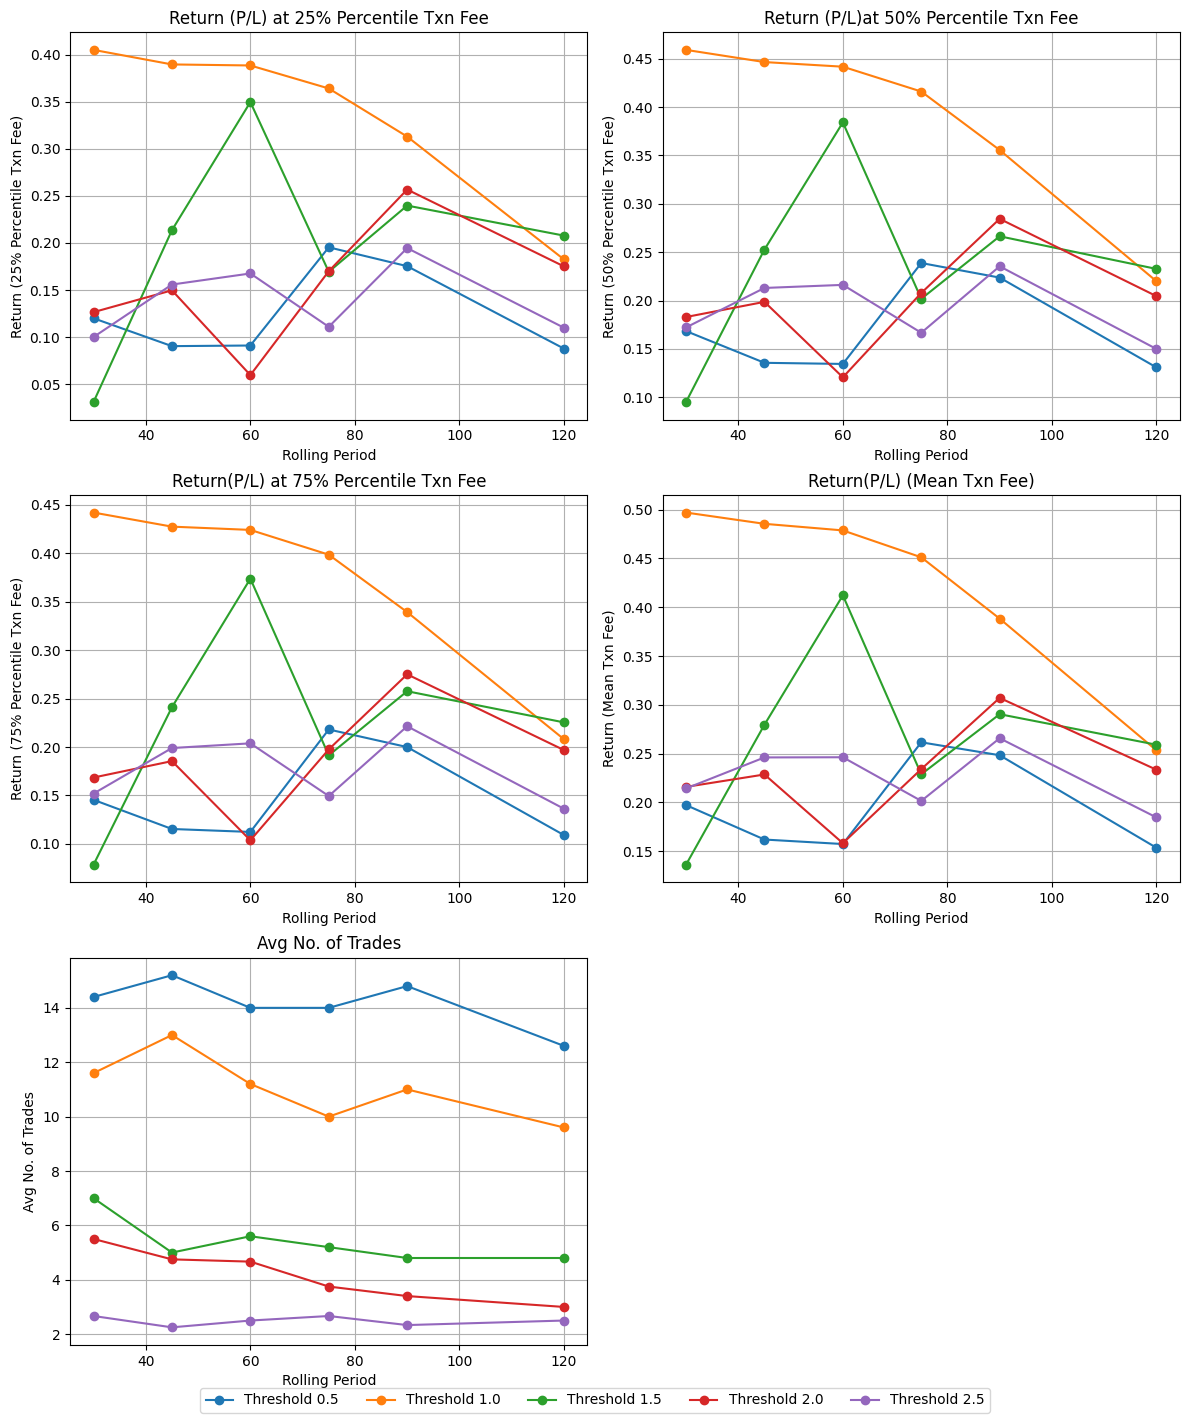

In [181]:
# Plotting all the plots for the fixed threshold
plot_diff_graphs(fixed_th_ds_pl)

# Dynamic Threshold: Z-Score
___

In [182]:
dynamic_th_ds_pl_z = pd.DataFrame(columns=['Threshold (Dynamic)','Rolling Period', 'Avg No. of Trades', \
                                    'Return (25% Percentile Txn Fee)', 'Max Return (25% Percentile Txn Fee)', 'Min Return (25% Percentile Txn Fee)', \
                                    'Return (50% Percentile Txn Fee)', 'Max Return (50% Percentile Txn Fee)', 'Min Return (50% Percentile Txn Fee)', \
                                    'Return (75% Percentile Txn Fee)', 'Max Return (75% Percentile Txn Fee)', 'Min Return (75% Percentile Txn Fee)', \
                                    'Return (Mean Txn Fee)', 'Max Return (Mean Txn Fee)', 'Min Return (Mean Txn Fee)', 'Sharpe Ratio'])

for t in thresholds:
    for r in rolling_period:
        transactions_history = pd.DataFrame(columns=['Date', 'Pair', 'Type of Transaction', 'ID', \
                                                     'L-Type', 'Long Asset', 'L-Price', 'Close L-Price',\
                                                     'Short Asset', 'S-Price','Close S-Price',   \
                                                     'P/L (25% Percentile Txn Fee)', 'P/L (Mean Txn Fee)', 'P/L (50% Percentile Txn Fee)',\
                                                     'P/L (75% Percentile Txn Fee)'])
        for p in pairing_keys:
            df = pairs[p]
            is_solana = False
            if(p == 'CAVE-CAVEWORLD'): 
                # We only have one nft-coin pair on the solana block-chain
                is_solana = True
            fixed_dm_df, fixed_dm_plot = distance_method_dynmaic_threshold_zscore(df, r, t)
            execute_pair_trading_dynamic_dm_zscore(fixed_dm_df, fixed_dm_plot, transactions_history, p, is_solana)
            #print(transactions_history)
        result, sharpe = get_summary_stats_pl(transactions_history)
        # print('**************',r,t,'**************')
        # print(result)
        rolling_window_stats_pl = {
            'Threshold (Dynamic)': t, 'Rolling Period' : r, 'Avg No. of Trades' : result['Count'].sum() / len(result), \
            'Return (25% Percentile Txn Fee)' :result['Avg_Return_25'].sum() / len(result), \
            'Max Return (25% Percentile Txn Fee)' :max(result['Max_Return_25']), \
            'Min Return (25% Percentile Txn Fee)': min(result['Min_Return_25']), \
            'Return (50% Percentile Txn Fee)':result['Avg_Return_Median'].sum() / len(result),\
            'Max Return (50% Percentile Txn Fee)':max(result['Max_Return_Median']), \
            'Min Return (50% Percentile Txn Fee)': min(result['Min_Return_Median']), \
            'Return (75% Percentile Txn Fee)':result['Avg_Return_75'].sum() / len(result), \
            'Max Return (75% Percentile Txn Fee)':max(result['Max_Return_75']), \
            'Min Return (75% Percentile Txn Fee)': min(result['Min_Return_75']), \
            'Return (Mean Txn Fee)':result['Avg_Return_Mean'].sum() / len(result), \
            'Max Return (Mean Txn Fee)':max(result['Max_Return_Mean']), \
            'Min Return (Mean Txn Fee)': min(result['Min_Return_Mean']), \
            'Sharpe Ratio' : sharpe
        }
        # dynamic_th_ds.loc[len(dynamic_th_ds.index)] = rolling_window_stats   
        dynamic_th_ds_pl_z.loc[len(dynamic_th_ds_pl_z.index)] = rolling_window_stats_pl

In [183]:
dynamic_th_ds_pl_z.set_index(['Threshold (Dynamic)', 'Rolling Period'], inplace=True)
dynamic_th_ds_pl_z

Avg No. of Trades  \
Threshold (Dynamic) Rolling Period                      
0.5                 30                          35.80   
                    45                          32.60   
                    60                          29.60   
                    75                          25.80   
                    90                          21.40   
                    120                         22.20   
1.0                 30                          25.60   
                    45                          26.00   
                    60                          20.60   
                    75                          19.60   
                    90                          18.20   
                    120                         16.60   
1.5                 30                          17.80   
                    45                          15.80   
                    60                          16.00   
                    75                           9.60   
                    90                          12.60   
                    120                         14.80   
2.0                 30                          10.40   
                    45                           8.40   
                    60                           9.20   
                    75                           6.20   
                    90                           6.60   
                    120                          9.20   
2.5                 30                           6.00   
                    45                           5.40   
                    60                           5.00   
                    75                           4.00   
                    90                           6.75   
                    120                          8.50   

                                    Return (25% Percentile Txn Fee)  \
Threshold (Dynamic) Rolling Period                                    
0.5                 30                                    -0.169863   
                    45                                    -0.115535   
                    60                                    -0.166034   
                    75                                    -0.457161   
                    90                                    -0.157473   
                    120                                   -0.088024   
1.0                 30                                    -0.150570   
                    45                                    -0.125669   
                    60                                    -0.159756   
                    75                                    -0.450195   
                    90                                    -0.135860   
                    120                                   -0.098961   
1.5                 30                                    -0.210109   
                    45                                    -0.203668   
                    60                                    -0.257543   
                    75                                    -0.527635   
                    90                                     0.074016   
                    120                                   -0.058524   
2.0                 30                                    -0.298267   
                    45                                    -0.299802   
                    60                                    -0.329885   
                    75                                    -0.455577   
                    90                                     0.168759   
                    120                                   -0.069478   
2.5                 30                                    -0.241516   
                    45                                    -0.300696   
                    60                                    -0.384617   
                    75                                    -0.064393   
                    90                                    -0.042493   
          

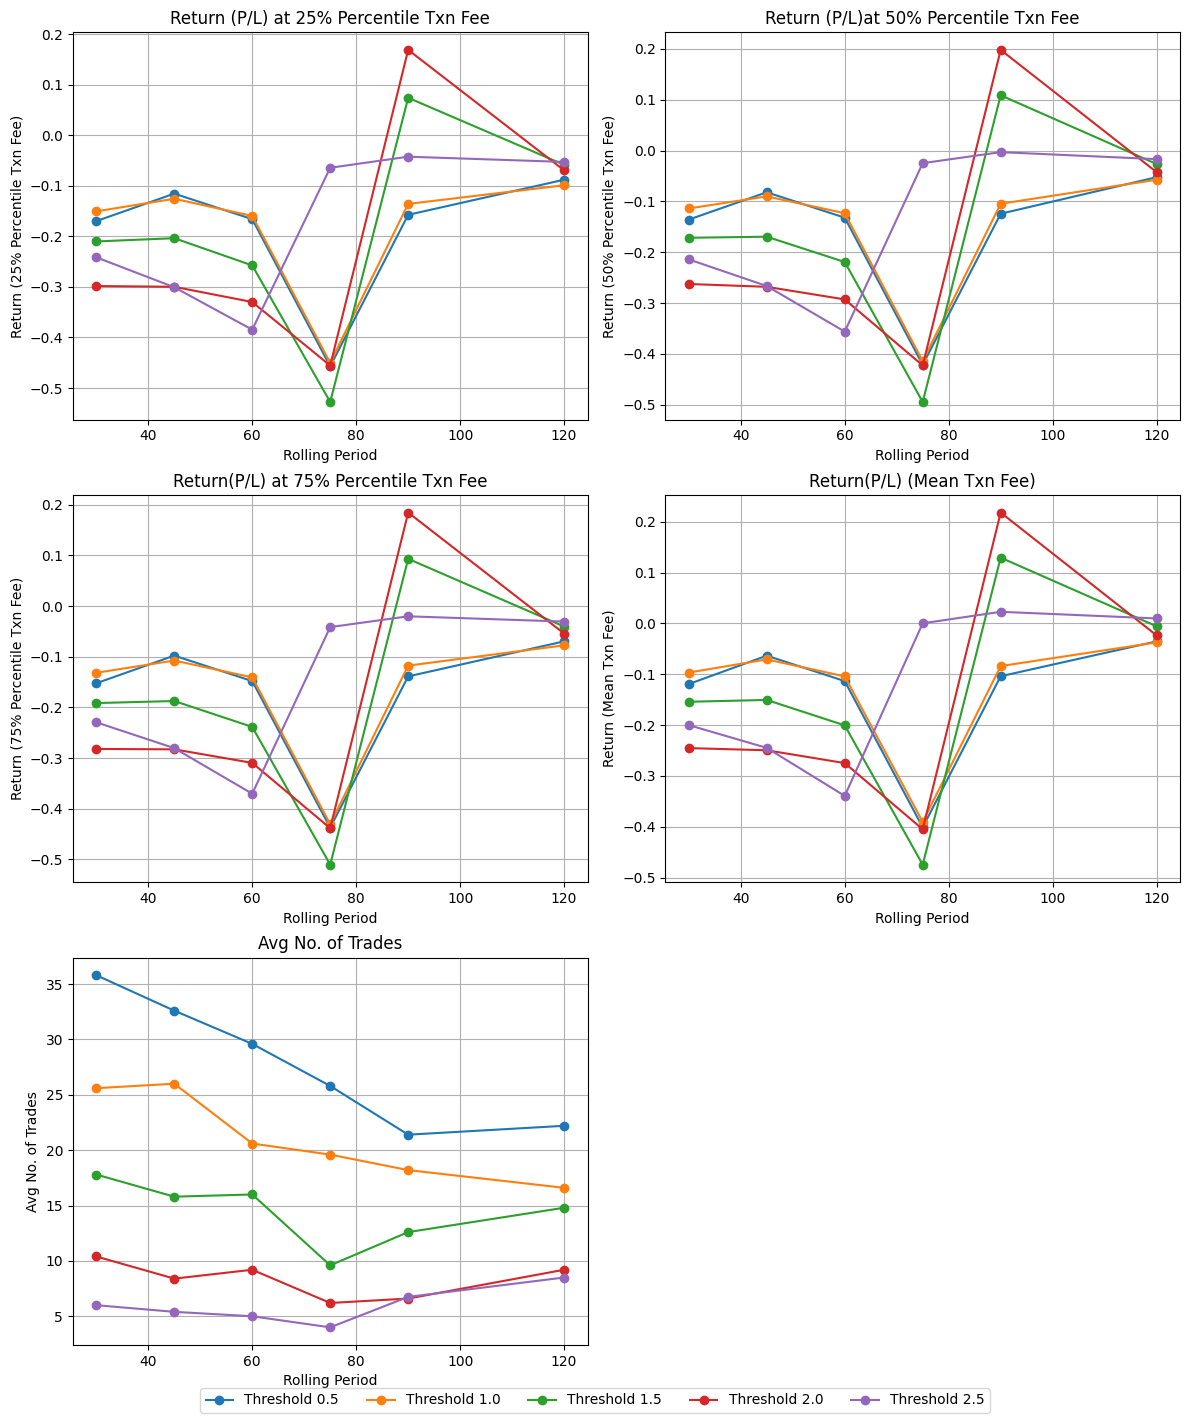

In [184]:
plot_diff_graphs(dynamic_th_ds_pl_z)

# Fixed Threshold: Spread
---

In [185]:
fixed_th_ds_pl_spread = pd.DataFrame(columns=['Threshold (Fixed)','Rolling Period', 'Avg No. of Trades', \
                                    'Return (25% Percentile Txn Fee)', 'Max Return (25% Percentile Txn Fee)', 'Min Return (25% Percentile Txn Fee)', \
                                    'Return (50% Percentile Txn Fee)', 'Max Return (50% Percentile Txn Fee)', 'Min Return (50% Percentile Txn Fee)', \
                                    'Return (75% Percentile Txn Fee)', 'Max Return (75% Percentile Txn Fee)', 'Min Return (75% Percentile Txn Fee)', \
                                    'Return (Mean Txn Fee)', 'Max Return (Mean Txn Fee)', 'Min Return (Mean Txn Fee)', 'Sharpe Ratio'])
temp = None
for t in thresholds:
    for r in rolling_period:
        transactions_history = pd.DataFrame(columns=['Date', 'Pair', 'Type of Transaction', 'ID', \
                                                     'L-Type', 'Long Asset', 'L-Price', 'Close L-Price',\
                                                     'Short Asset', 'S-Price','Close S-Price',   \
                                                     'P/L (25% Percentile Txn Fee)', 'P/L (Mean Txn Fee)', 'P/L (50% Percentile Txn Fee)',\
                                                     'P/L (75% Percentile Txn Fee)'])
        for p in pairing_keys:
            is_solana = False
            if(p == 'CAVE-CAVEWORLD'): 
                # We only have one nft-coin pair on the solana block-chain
                is_solana = True
            df = pairs[p]
            fixed_dm_df, fixed_dm_plot = distance_method_fixed_threshhold_spread(df, r, t)
            execute_pair_trading_fixed_dm_spread(fixed_dm_df, fixed_dm_plot, transactions_history, p, is_solana)
            
        result, sharpe = get_summary_stats_pl(transactions_history)
        rolling_window_stats_pl = {'Threshold (Fixed)': t, 'Rolling Period' : r, 'Avg No. of Trades' : result['Count'].sum() / len(result), \
                                'Return (25% Percentile Txn Fee)' :result['Avg_Return_25'].sum() / len(result), \
                                'Max Return (25% Percentile Txn Fee)' :max(result['Max_Return_25']), \
                                'Min Return (25% Percentile Txn Fee)': min(result['Min_Return_25']), \
                                'Return (50% Percentile Txn Fee)':result['Avg_Return_Median'].sum() / len(result),\
                                'Max Return (50% Percentile Txn Fee)':max(result['Max_Return_Median']), \
                                'Min Return (50% Percentile Txn Fee)': min(result['Min_Return_Median']), \
                                'Return (75% Percentile Txn Fee)':result['Avg_Return_75'].sum() / len(result), \
                                'Max Return (75% Percentile Txn Fee)':max(result['Max_Return_75']), \
                                'Min Return (75% Percentile Txn Fee)': min(result['Min_Return_75']), \
                                'Return (Mean Txn Fee)':result['Avg_Return_Mean'].sum() / len(result), \
                                'Max Return (Mean Txn Fee)':max(result['Max_Return_Mean']), \
                                'Min Return (Mean Txn Fee)': min(result['Min_Return_Mean']), \
                                'Sharpe Ratio' : sharpe}
        
        # fixed_th_ds_log.loc[len(fixed_th_ds_log.index)] = rolling_window_stats 
        fixed_th_ds_pl_spread.loc[len(fixed_th_ds_pl_spread.index)] = rolling_window_stats_pl


In [186]:
fixed_th_ds_pl_spread.set_index(['Threshold (Fixed)', 'Rolling Period'], inplace=True)
fixed_th_ds_pl_spread

Avg No. of Trades  \
Threshold (Fixed) Rolling Period                      
0.5               30                      14.400000   
                  45                      15.200000   
                  60                      14.000000   
                  75                      14.000000   
                  90                      14.800000   
                  120                     12.600000   
1.0               30                      11.600000   
                  45                      13.000000   
                  60                      11.200000   
                  75                      10.000000   
                  90                      11.000000   
                  120                      9.600000   
1.5               30                       7.000000   
                  45                       5.000000   
                  60                       5.600000   
                  75                       5.200000   
                  90                       4.800000   
                  120                      4.800000   
2.0               30                       5.500000   
                  45                       4.750000   
                  60                       4.666667   
                  75                       3.750000   
                  90                       3.400000   
                  120                      3.000000   
2.5               30                       2.666667   
                  45                       2.250000   
                  60                       2.500000   
                  75                       2.666667   
                  90                       2.333333   
                  120                      2.500000   

                                  Return (25% Percentile Txn Fee)  \
Threshold (Fixed) Rolling Period                                    
0.5               30                                     0.120001   
                  45                                     0.090428   
                  60                                     0.091095   
                  75                                     0.195337   
                  90                                     0.175320   
                  120                                    0.087790   
1.0               30                                     0.404925   
                  45                                     0.389477   
                  60                                     0.388383   
                  75                                     0.363968   
                  90                                     0.312864   
                  120                                    0.182445   
1.5               30                                     0.031128   
                  45                                     0.213519   
                  60                                     0.349523   
                  75                                     0.169341   
                  90                                     0.239634   
                  120                                    0.207754   
2.0               30                                     0.126521   
                  45                                     0.149688   
                  60                                     0.059701   
                  75                                     0.169979   
                  90                                     0.256666   
                  120                                    0.175064   
2.5               30                                     0.100097   
                  45                                     0.155819   
                  60                                     0.167571   
                  75                                     0.110929   
                  90                                     0.194518   
                  120                                    0.109948   

                                  Max Return (25% Percentile Txn

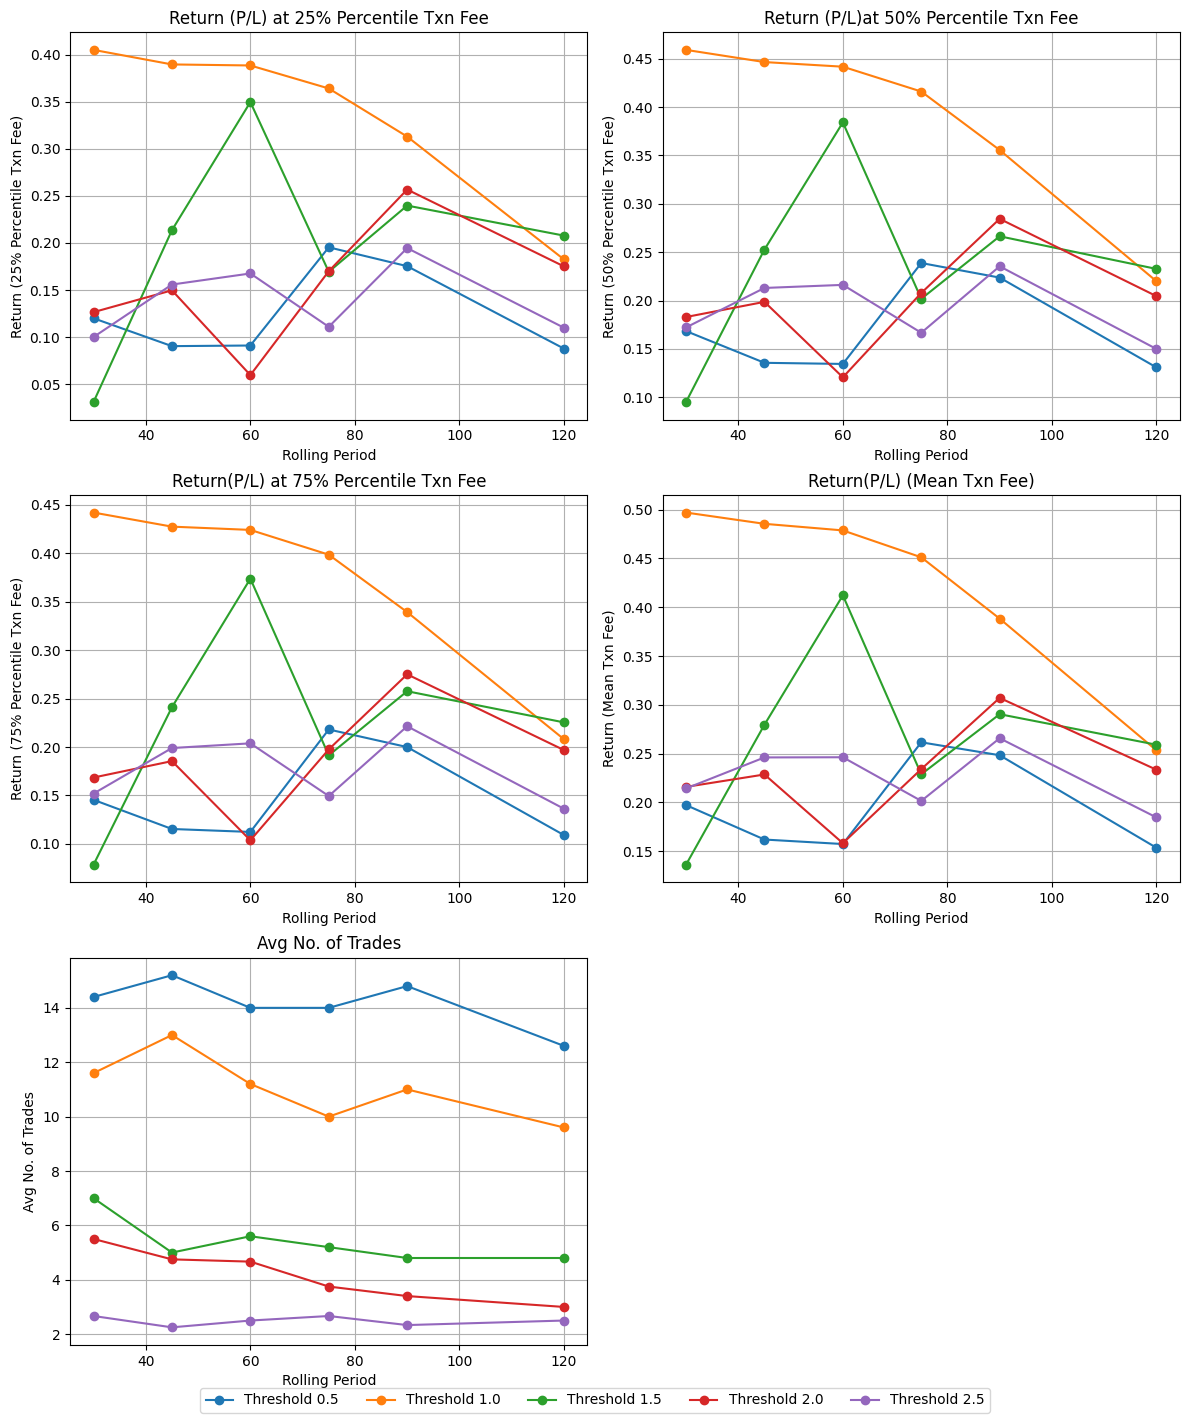

In [187]:
plot_diff_graphs(fixed_th_ds_pl_spread)

# Dynamic Threshold: Spread
___

In [188]:
dynamic_th_ds_pl = pd.DataFrame(columns=['Threshold (Dynamic)','Rolling Period', 'Avg No. of Trades', \
                                    'Return (25% Percentile Txn Fee)', 'Max Return (25% Percentile Txn Fee)', 'Min Return (25% Percentile Txn Fee)', \
                                    'Return (50% Percentile Txn Fee)', 'Max Return (50% Percentile Txn Fee)', 'Min Return (50% Percentile Txn Fee)', \
                                    'Return (75% Percentile Txn Fee)', 'Max Return (75% Percentile Txn Fee)', 'Min Return (75% Percentile Txn Fee)', \
                                    'Return (Mean Txn Fee)', 'Max Return (Mean Txn Fee)', 'Min Return (Mean Txn Fee)', 'Sharpe Ratio'])

for t in thresholds:
    for r in rolling_period:
        transactions_history = pd.DataFrame(columns=['Date', 'Pair', 'Type of Transaction', 'ID', \
                                                     'L-Type', 'Long Asset', 'L-Price', 'Close L-Price',\
                                                     'Short Asset', 'S-Price','Close S-Price',   \
                                                     'P/L (25% Percentile Txn Fee)', 'P/L (Mean Txn Fee)', 'P/L (50% Percentile Txn Fee)',\
                                                     'P/L (75% Percentile Txn Fee)'])
        for p in pairing_keys:
            df = pairs[p]
            is_solana = False
            if(p == 'CAVE-CAVEWORLD'): 
                # We only have one nft-coin pair on the solana block-chain
                is_solana = True
            fixed_dm_df, fixed_dm_plot = distance_method_dynamic_threshhold(df, r, t)
            execute_pair_trading_dynamic_dm(fixed_dm_df, fixed_dm_plot, transactions_history, p, is_solana)
        result, sharpe = get_summary_stats_pl(transactions_history)
        rolling_window_stats_pl = {
            'Threshold (Dynamic)': t, 'Rolling Period' : r, 'Avg No. of Trades' : result['Count'].sum() / len(result), \
            'Return (25% Percentile Txn Fee)' :result['Avg_Return_25'].sum() / len(result), \
            'Max Return (25% Percentile Txn Fee)' :max(result['Max_Return_25']), \
            'Min Return (25% Percentile Txn Fee)': min(result['Min_Return_25']), \
            'Return (50% Percentile Txn Fee)':result['Avg_Return_Median'].sum() / len(result),\
            'Max Return (50% Percentile Txn Fee)':max(result['Max_Return_Median']), \
            'Min Return (50% Percentile Txn Fee)': min(result['Min_Return_Median']), \
            'Return (75% Percentile Txn Fee)':result['Avg_Return_75'].sum() / len(result), \
            'Max Return (75% Percentile Txn Fee)':max(result['Max_Return_75']), \
            'Min Return (75% Percentile Txn Fee)': min(result['Min_Return_75']), \
            'Return (Mean Txn Fee)':result['Avg_Return_Mean'].sum() / len(result), \
            'Max Return (Mean Txn Fee)':max(result['Max_Return_Mean']), \
            'Min Return (Mean Txn Fee)': min(result['Min_Return_Mean']), \
            'Sharpe Ratio' : sharpe
        }
        # dynamic_th_ds.loc[len(dynamic_th_ds.index)] = rolling_window_stats   
        dynamic_th_ds_pl.loc[len(dynamic_th_ds_pl.index)] = rolling_window_stats_pl

In [189]:
dynamic_th_ds_pl.set_index(['Threshold (Dynamic)', 'Rolling Period'], inplace=True)
dynamic_th_ds_pl

Avg No. of Trades  \
Threshold (Dynamic) Rolling Period                      
0.5                 30                           36.6   
                    45                           26.8   
                    60                           23.8   
                    75                           20.0   
                    90                           14.6   
                    120                          12.2   
1.0                 30                           34.2   
                    45                           25.0   
                    60                           20.4   
                    75                           17.2   
                    90                           14.6   
                    120                          14.4   
1.5                 30                           21.4   
                    45                           18.2   
                    60                           15.0   
                    75                           16.0   
                    90                           12.6   
                    120                           9.4   
2.0                 30                           19.6   
                    45                           12.6   
                    60                           10.4   
                    75                            9.0   
                    90                            7.0   
                    120                           4.8   
2.5                 30                            9.4   
                    45                            9.0   
                    60                            6.4   
                    75                            5.0   
                    90                            3.8   
                    120                           3.5   

                                    Return (25% Percentile Txn Fee)  \
Threshold (Dynamic) Rolling Period                                    
0.5                 30                                    -0.064279   
                    45                                    -0.122138   
                    60                                    -0.146978   
                    75                                    -0.147278   
                    90                                    -0.099838   
                    120                                   -0.043053   
1.0                 30                                    -0.041256   
                    45                                    -0.087769   
                    60                                    -0.159045   
                    75                                    -0.195074   
                    90                                    -0.038330   
                    120                                    0.022423   
1.5                 30                                    -0.116419   
                    45                                    -0.173230   
                    60                                    -0.193339   
                    75                                    -0.086346   
                    90                                    -0.136142   
                    120                                    0.027301   
2.0                 30                                    -0.074493   
                    45                                    -0.193382   
                    60                                    -0.280359   
                    75                                    -0.201934   
                    90                                    -0.137288   
                    120                                    0.117846   
2.5                 30                                    -0.135638   
                    45                                    -0.110022   
                    60                                    -0.182071   
                    75                                    -0.102676   
                    90                                    -0.082626   
          

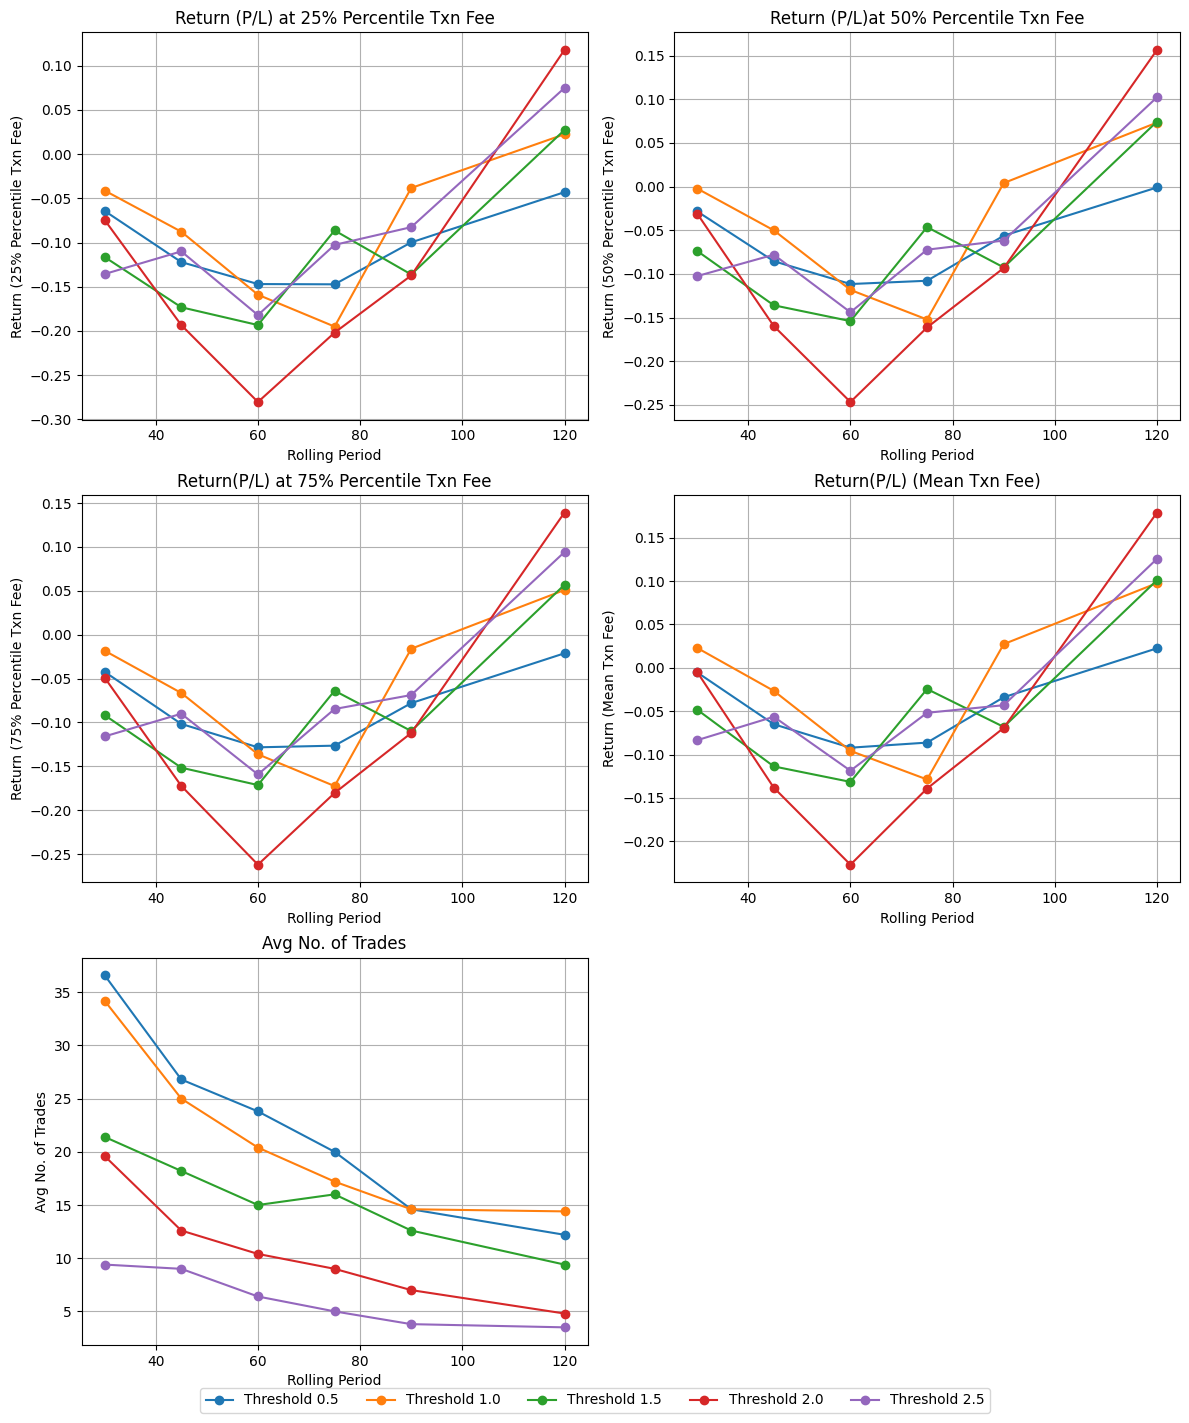

In [190]:
plot_diff_graphs(dynamic_th_ds_pl)

# Dynamic Threshold: Spread w/ Stop Loss
---

In [191]:
dynamic_sl_th_ds_pl = pd.DataFrame(columns=['Threshold (Dynamic)','Rolling Period', 'Avg No. of Trades', \
                                    'Return (25% Percentile Txn Fee)', 'Max Return (25% Percentile Txn Fee)', 'Min Return (25% Percentile Txn Fee)', \
                                    'Return (50% Percentile Txn Fee)', 'Max Return (50% Percentile Txn Fee)', 'Min Return (50% Percentile Txn Fee)', \
                                    'Return (75% Percentile Txn Fee)', 'Max Return (75% Percentile Txn Fee)', 'Min Return (75% Percentile Txn Fee)', \
                                    'Return (Mean Txn Fee)', 'Max Return (Mean Txn Fee)', 'Min Return (Mean Txn Fee)', 'Sharpe Ratio'])

for t in thresholds:
    for r in rolling_period:
        transactions_history = pd.DataFrame(columns=['Date', 'Pair', 'Type of Transaction', 'ID', \
                                                     'L-Type', 'Long Asset', 'L-Price', 'Close L-Price',\
                                                     'Short Asset', 'S-Price','Close S-Price',   \
                                                     'P/L (25% Percentile Txn Fee)', 'P/L (Mean Txn Fee)', 'P/L (50% Percentile Txn Fee)',\
                                                     'P/L (75% Percentile Txn Fee)'])
        for p in pairing_keys:
            df = pairs[p]
            is_solana = False
            if(p == 'CAVE-CAVEWORLD'): 
                # We only have one nft-coin pair on the solana block-chain
                is_solana = True
            fixed_dm_df, fixed_dm_plot = distance_method_dynamic_threshhold_stop_loss(df, r, t)
            execute_pair_trading_dynamic_dm_stop_loss(fixed_dm_df, fixed_dm_plot, transactions_history, p, is_solana)
        result, sharpe = get_summary_stats_pl(transactions_history)
        rolling_window_stats_pl = {
            'Threshold (Dynamic)': t, 'Rolling Period' : r, 'Avg No. of Trades' : result['Count'].sum() / len(result), \
            'Return (25% Percentile Txn Fee)' :result['Avg_Return_25'].sum() / len(result), \
            'Max Return (25% Percentile Txn Fee)' :max(result['Max_Return_25']), \
            'Min Return (25% Percentile Txn Fee)': min(result['Min_Return_25']), \
            'Return (50% Percentile Txn Fee)':result['Avg_Return_Median'].sum() / len(result),\
            'Max Return (50% Percentile Txn Fee)':max(result['Max_Return_Median']), \
            'Min Return (50% Percentile Txn Fee)': min(result['Min_Return_Median']), \
            'Return (75% Percentile Txn Fee)':result['Avg_Return_75'].sum() / len(result), \
            'Max Return (75% Percentile Txn Fee)':max(result['Max_Return_75']), \
            'Min Return (75% Percentile Txn Fee)': min(result['Min_Return_75']), \
            'Return (Mean Txn Fee)':result['Avg_Return_Mean'].sum() / len(result), \
            'Max Return (Mean Txn Fee)':max(result['Max_Return_Mean']), \
            'Min Return (Mean Txn Fee)': min(result['Min_Return_Mean']), \
            'Sharpe Ratio' : sharpe
        }
        # dynamic_th_ds.loc[len(dynamic_th_ds.index)] = rolling_window_stats   
        dynamic_sl_th_ds_pl.loc[len(dynamic_sl_th_ds_pl.index)] = rolling_window_stats_pl

In [192]:
# dynamic_th_ds.set_index(['Threshold (Dynamic)', 'Rolling Period'], inplace=True)
dynamic_sl_th_ds_pl.set_index(['Threshold (Dynamic)', 'Rolling Period'], inplace=True)
dynamic_sl_th_ds_pl

Avg No. of Trades  \
Threshold (Dynamic) Rolling Period                      
0.5                 30                           37.4   
                    45                           27.6   
                    60                           24.4   
                    75                           20.4   
                    90                           14.8   
                    120                          12.6   
1.0                 30                           35.0   
                    45                           25.6   
                    60                           21.2   
                    75                           17.4   
                    90                           14.8   
                    120                          14.6   
1.5                 30                           22.2   
                    45                           19.2   
                    60                           16.0   
                    75                           16.4   
                    90                           13.0   
                    120                           9.6   
2.0                 30                           20.4   
                    45                           13.4   
                    60                           10.8   
                    75                            9.4   
                    90                            7.6   
                    120                           5.4   
2.5                 30                            9.8   
                    45                            9.0   
                    60                            6.6   
                    75                            5.2   
                    90                            3.8   
                    120                           3.5   

                                    Return (25% Percentile Txn Fee)  \
Threshold (Dynamic) Rolling Period                                    
0.5                 30                                    -0.119040   
                    45                                    -0.111084   
                    60                                    -0.120520   
                    75                                    -0.176517   
                    90                                    -0.272451   
                    120                                   -0.203891   
1.0                 30                                    -0.095428   
                    45                                    -0.074754   
                    60                                    -0.113448   
                    75                                    -0.176185   
                    90                                    -0.079297   
                    120                                   -0.063964   
1.5                 30                                    -0.121799   
                    45                                    -0.163667   
                    60                                    -0.150889   
                    75                                    -0.074765   
                    90                                    -0.132527   
                    120                                   -0.023700   
2.0                 30                                    -0.127726   
                    45                                    -0.213395   
                    60                                    -0.240135   
                    75                                    -0.200230   
                    90                                    -0.124872   
                    120                                    0.023878   
2.5                 30                                    -0.186643   
                    45                                    -0.182888   
                    60                                    -0.211864   
                    75                                    -0.160856   
                    90                                    -0.173546   
          

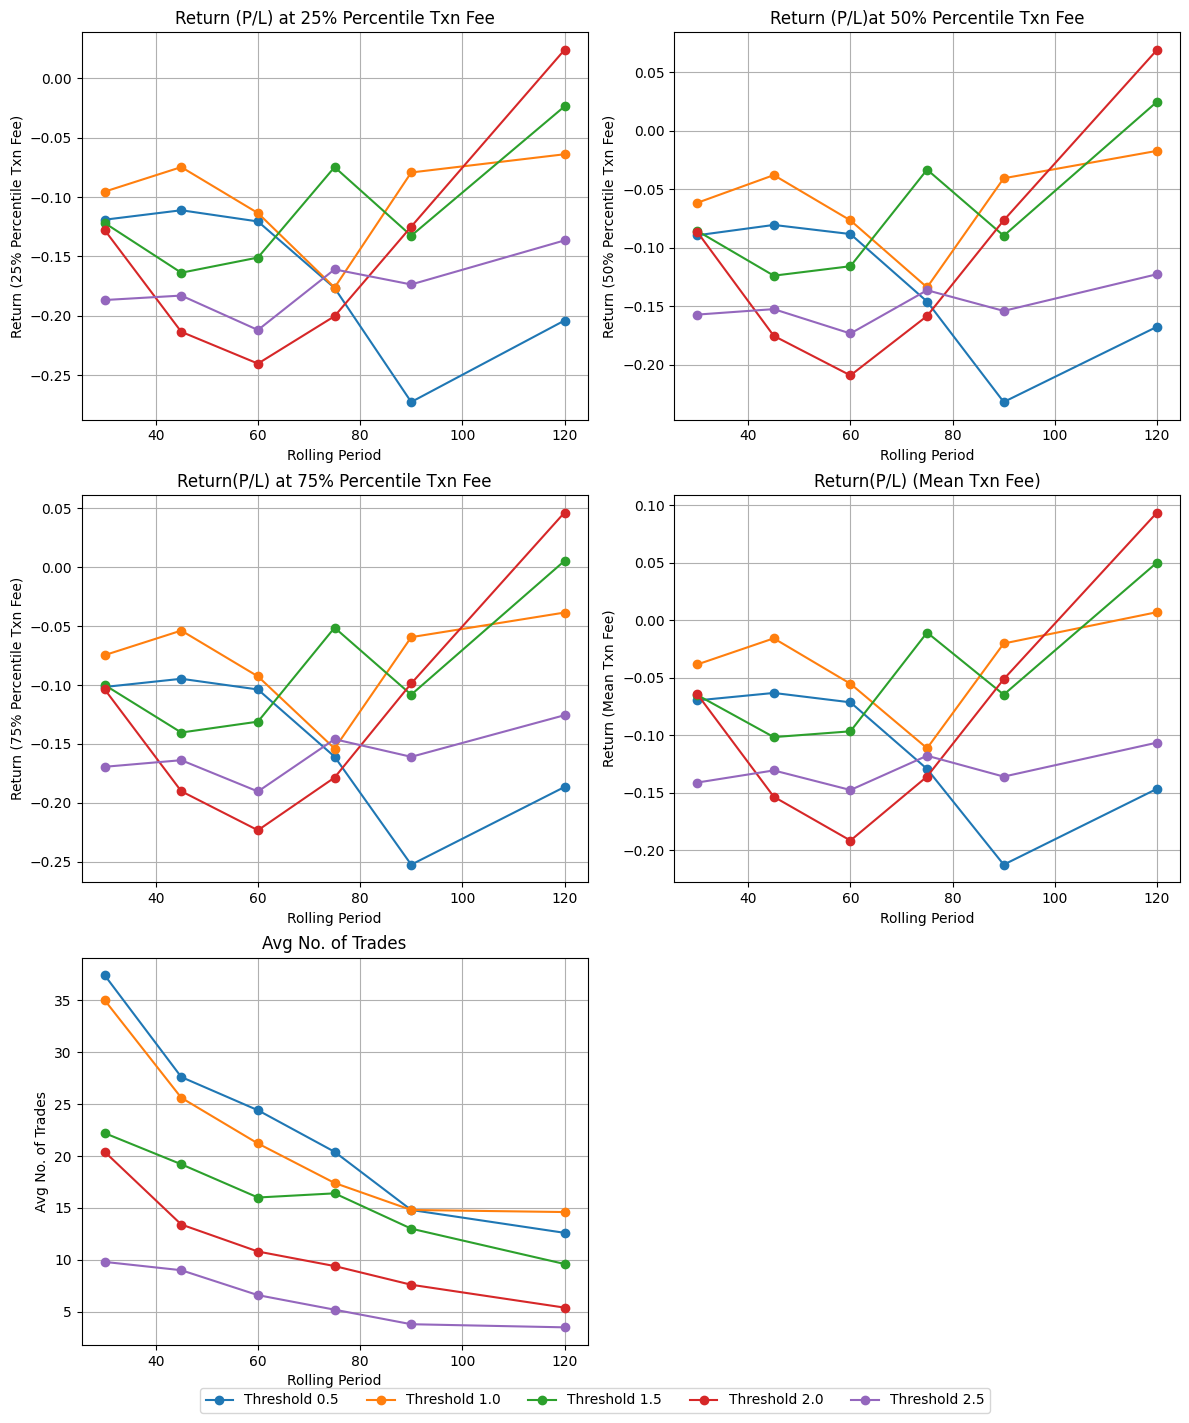

In [193]:
plot_diff_graphs(dynamic_sl_th_ds_pl)

# Benchmark portfolio

We also need a benchmark portfolio to compare results. For this we will be using the Buy and Hold strategy. The aim is to check whether passivley maintaining a portfolio of the same pairs selected and traded would be more profitable than actually implementing the strategy. I shall be using the dynamic thresh-hold principle for this as it will involve more number of trades

## Dynamic threshhold
___


In [194]:
dynamic_bm_pl = pd.DataFrame(columns=['Benchmark (Dynamic)','Rolling Period', 'Avg No. of Trades', \
                                    'Return (25% Percentile Txn Fee)', 'Max Return (25% Percentile Txn Fee)', 'Min Return (25% Percentile Txn Fee)', \
                                    'Return (50% Percentile Txn Fee)', 'Max Return (50% Percentile Txn Fee)', 'Min Return (50% Percentile Txn Fee)', \
                                    'Return (75% Percentile Txn Fee)', 'Max Return (75% Percentile Txn Fee)', 'Min Return (75% Percentile Txn Fee)', \
                                    'Return (Mean Txn Fee)', 'Max Return (Mean Txn Fee)', 'Min Return (Mean Txn Fee)', 'Sharpe Ratio'])

for t in thresholds:
    for r in rolling_period:
        transactions_history = pd.DataFrame(columns=['Date', 'Pair', 'Type of Transaction', 'ID', \
                                                     'L-Type', 'Long Asset', 'L-Price', 'Close L-Price',\
                                                     'Short Asset', 'S-Price','Close S-Price',   \
                                                     'P/L (25% Percentile Txn Fee)', 'P/L (Mean Txn Fee)', 'P/L (50% Percentile Txn Fee)',\
                                                     'P/L (75% Percentile Txn Fee)'])
        for p in pairing_keys:
            df = pairs[p]
            is_solana = False
            if(p == 'CAVE-CAVEWORLD'): 
                # We only have one nft-coin pair on the solana block-chain
                is_solana = True
            fixed_dm_df, fixed_dm_plot = distance_method_dynamic_threshhold(df, r, t)
            execute_pair_trading_benchmark_dm(fixed_dm_df, fixed_dm_plot, transactions_history, p, is_solana)
        
        result, sharpe = get_summary_stats_pl(transactions_history)
        rolling_window_stats_pl = {
            'Benchmark (Dynamic)': t, 'Rolling Period' : r, 'Avg No. of Trades' : result['Count'].sum() / len(result), \
            'Return (25% Percentile Txn Fee)' :result['Avg_Return_25'].sum() / len(result), \
            'Max Return (25% Percentile Txn Fee)' :max(result['Max_Return_25']), \
            'Min Return (25% Percentile Txn Fee)': min(result['Min_Return_25']), \
            'Return (50% Percentile Txn Fee)':result['Avg_Return_Median'].sum() / len(result),\
            'Max Return (50% Percentile Txn Fee)':max(result['Max_Return_Median']), \
            'Min Return (50% Percentile Txn Fee)': min(result['Min_Return_Median']), \
            'Return (75% Percentile Txn Fee)':result['Avg_Return_75'].sum() / len(result), \
            'Max Return (75% Percentile Txn Fee)':max(result['Max_Return_75']), \
            'Min Return (75% Percentile Txn Fee)': min(result['Min_Return_75']), \
            'Return (Mean Txn Fee)':result['Avg_Return_Mean'].sum() / len(result), \
            'Max Return (Mean Txn Fee)':max(result['Max_Return_Mean']), \
            'Min Return (Mean Txn Fee)': min(result['Min_Return_Mean']), \
            'Sharpe Ratio' : sharpe
        }
        # dynamic_bm.loc[len(dynamic_bm.index)] = rolling_window_stats   
        dynamic_bm_pl.loc[len(dynamic_bm_pl.index)] = rolling_window_stats_pl

In [195]:
# dynamic_bm.set_index(['Benchmark (Dynamic)', 'Rolling Period'], inplace=True)
dynamic_bm_pl.set_index(['Benchmark (Dynamic)', 'Rolling Period'], inplace=True)
dynamic_bm_pl

Avg No. of Trades  \
Benchmark (Dynamic) Rolling Period                      
0.5                 30                          38.20   
                    45                          28.60   
                    60                          25.80   
                    75                          21.80   
                    90                          16.00   
                    120                         13.20   
1.0                 30                          37.80   
                    45                          26.80   
                    60                          22.40   
                    75                          19.20   
                    90                          16.40   
                    120                         15.40   
1.5                 30                          23.60   
                    45                          20.40   
                    60                          17.80   
                    75                          17.80   
                    90                          14.00   
                    120                         10.00   
2.0                 30                          21.80   
                    45                          14.20   
                    60                          12.00   
                    75                          10.00   
                    90                           7.80   
                    120                          6.20   
2.5                 30                          10.00   
                    45                           9.80   
                    60                           7.40   
                    75                           5.40   
                    90                           4.40   
                    120                          4.25   

                                    Return (25% Percentile Txn Fee)  \
Benchmark (Dynamic) Rolling Period                                    
0.5                 30                                    -0.101908   
                    45                                    -0.159656   
                    60                                    -0.108281   
                    75                                    -0.136882   
                    90                                    -0.081024   
                    120                                   -0.026018   
1.0                 30                                    -0.052321   
                    45                                    -0.084791   
                    60                                    -0.010424   
                    75                                    -0.142107   
                    90                                    -0.034375   
                    120                                    0.006235   
1.5                 30                                    -0.056554   
                    45                                    -0.228892   
                    60                                    -0.119222   
                    75                                    -0.072676   
                    90                                    -0.064787   
                    120                                    0.042605   
2.0                 30                                    -0.119988   
                    45                                    -0.186127   
                    60                                    -0.183417   
                    75                                    -0.221940   
                    90                                    -0.069598   
                    120                                    0.133206   
2.5                 30                                    -0.050022   
                    45                                    -0.090384   
                    60                                    -0.099617   
                    75                                    -0.060057   
                    90                                     0.022683   
          

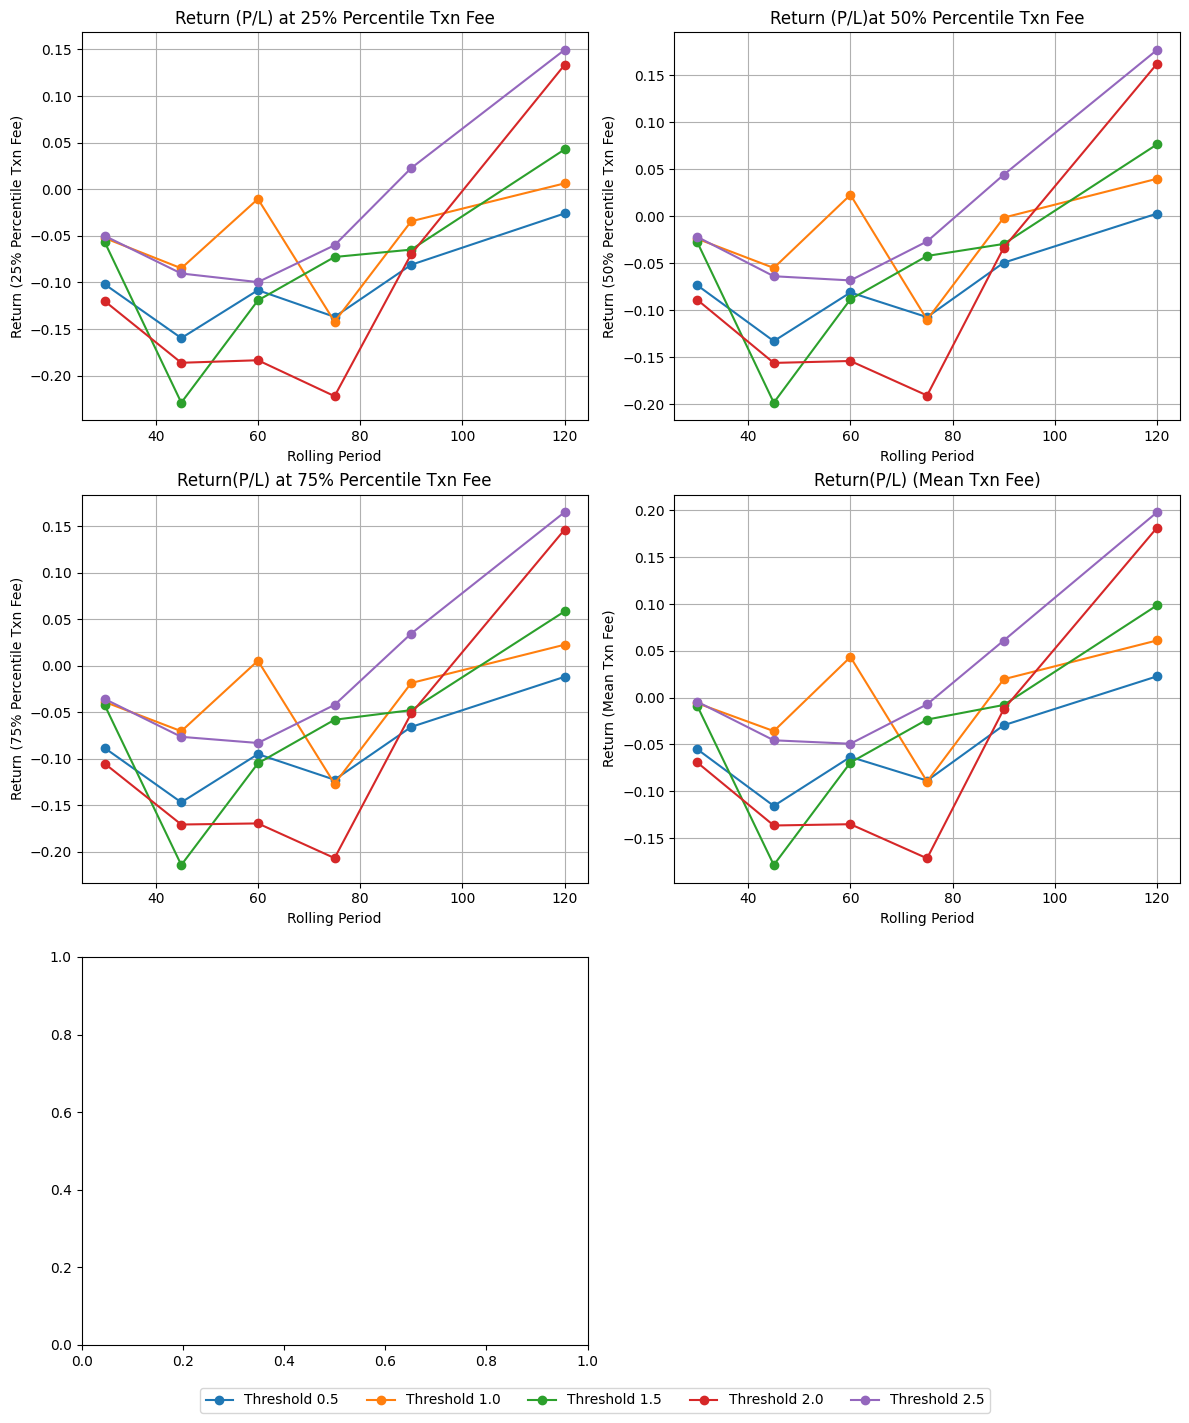

In [196]:
# Note: buy and hold will not need to plot number of trades
plot_diff_graphs(dynamic_bm_pl, False)

# Exploratory Analysis of the Data
____

This part of the notebook will focus on the graphs that were used to showcase some visualizations:

In [197]:
pairs = {}
pairing = [['BYTES', 'NEOTOKYO-CITIZENS'], ['CAVE', 'CAVEWORLD'], ['GOB', 'GOONSOFBALATROON'],\
           ['BLOOD', 'IMPOSTORS-GENESIS-ALIENS'], ['APE', 'BORED-APE-YACHT-CLUB']]

In [198]:
def combineCoinNft(c, n, coins, nfts):
    tempOne = coins[coins['Symbol'] == c]
    tempTwo = nfts[nfts['NFT'] == n]
    # Inner merge on 'Date' column
    inner_merged = pd.merge(tempOne, tempTwo, on='Date', how='inner')
    inner_merged = inner_merged.rename(columns={'Symbol': 'COIN', 'floorUsd' :'NftPrice', 'Close' :'CoinPrice'})
    return inner_merged

In [199]:
for p in pairing:
    key = p[0] + '-' + p[1]
    coinNftPrice = combineCoinNft(p[0], p[1], coins, nfts)
    pairs[key] = coinNftPrice

# Dynamic Threshold Pair Trading
___

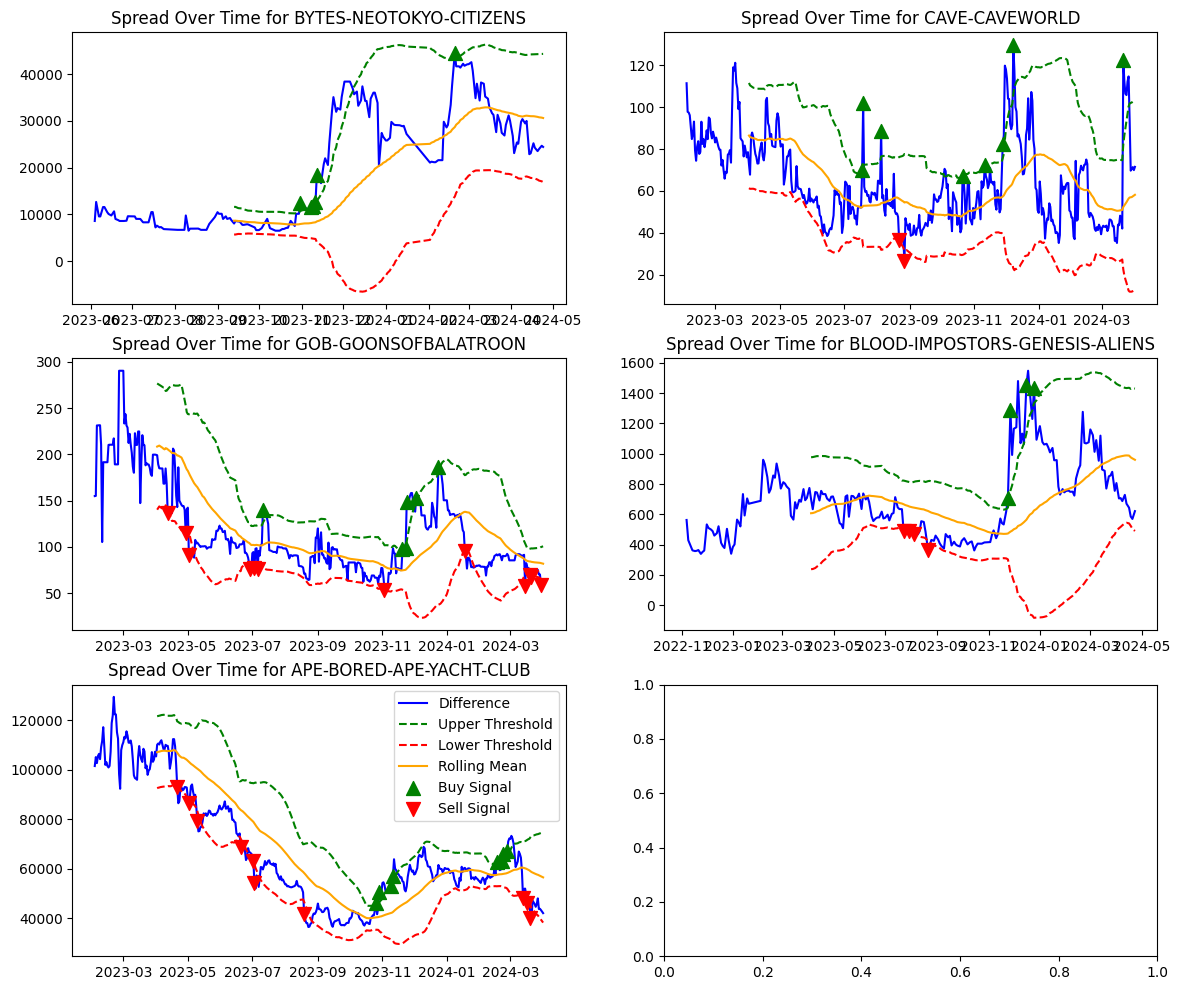

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [200]:
def dynamic_thresh_dist(df, pair, formation_duration, ax, show_legend=False):
    df['Diff'] = df['NftPrice'] - df['CoinPrice']
    df['Rolling Mean'] = df['Diff'].rolling(window=formation_duration).mean()
    df['Rolling Std'] = df['Diff'].rolling(window=formation_duration).std()

    # Define dynamic upper and lower thresholds
    upper_threshold = df['Rolling Mean'] + 2 * df['Rolling Std']
    lower_threshold = df['Rolling Mean'] - 2 * df['Rolling Std']

    # Identify crossing points for buy and sell signals
    fixed_buy_signals = (df['Diff'] > upper_threshold) & (df['Diff'].shift(1) <= upper_threshold)
    fixed_sell_signals = (df['Diff'] < lower_threshold) & (df['Diff'].shift(1) >= lower_threshold)

    # Plotting
    ax.plot(df['Date'], df['Diff'], label='Difference', color='blue')
    ax.plot(df['Date'], upper_threshold, linestyle='--', label='Upper Threshold', color='green')
    ax.plot(df['Date'], lower_threshold, linestyle='--', label='Lower Threshold', color='red')
    ax.plot(df['Date'], df['Rolling Mean'], linestyle='-', label='Rolling Mean', color='orange')
    plt.figure(figsize=(5, 5))
    ax.scatter(df['Date'][fixed_buy_signals], df['Diff'][fixed_buy_signals], color='green', marker='^', label='Buy Signal', s=100, zorder=5)
    ax.scatter(df['Date'][fixed_sell_signals], df['Diff'][fixed_sell_signals], color='red', marker='v', label='Sell Signal', s=100, zorder=5)

    ax.set_title('Spread Over Time for ' + pair)

    if show_legend:
        ax.legend()

# Assuming 'pairs' is a dictionary with pair names as keys and dataframes as values
fig, axes = plt.subplots(nrows=(len(pairs) + 1) // 2, ncols=2, figsize=(14, 5 * len(pairs) // 2))
axes = axes.flatten()  # Flatten to 1D array for easier iteration

for i, p in enumerate(pairs):
    df = pairs[p]
    # Show legend only for the last plot
    show_legend = (i == len(pairs) - 1)
    dynamic_thresh_dist(df, p, 60, axes[i], show_legend=show_legend)

# Adjust layout, increase vertical spacing
plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.tight_layout()
plt.show()


# Dynamic Threshold with stop loss
---

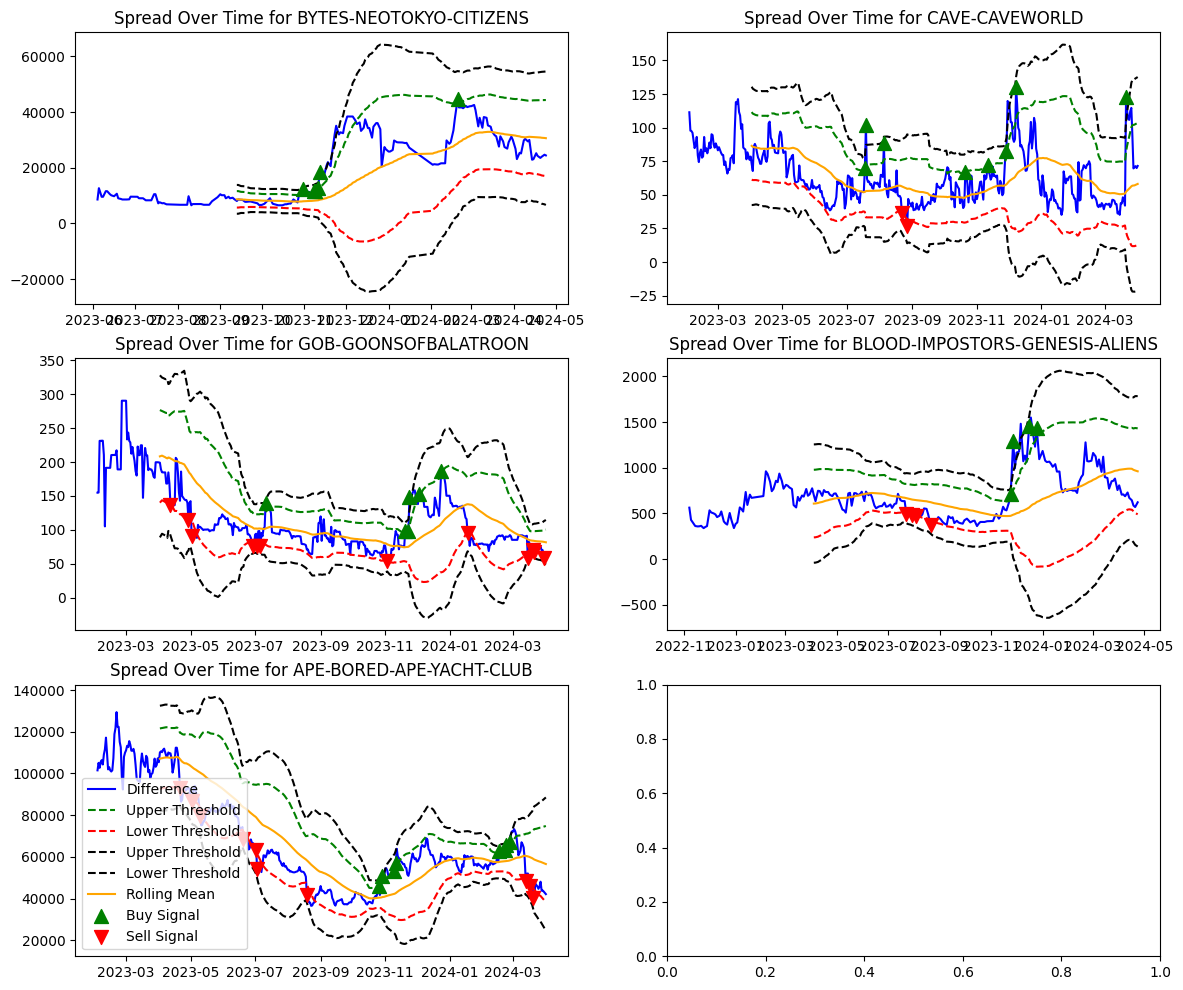

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [201]:
def dynamic_thresh_dist(df, pair, formation_duration, ax, show_legend=False):
    df['Diff'] = df['NftPrice'] - df['CoinPrice']
    df['Rolling Mean'] = df['Diff'].rolling(window=formation_duration).mean()
    df['Rolling Std'] = df['Diff'].rolling(window=formation_duration).std()

    # Define dynamic upper and lower thresholds
    upper_threshold = df['Rolling Mean'] + 2 * df['Rolling Std']
    lower_threshold = df['Rolling Mean'] - 2 * df['Rolling Std']
    upper_threshold_sl = df['Rolling Mean'] + 3.5 * df['Rolling Std']
    lower_threshold_sl = df['Rolling Mean'] - 3.5 * df['Rolling Std']

    # Identify crossing points for buy and sell signals
    fixed_buy_signals = (df['Diff'] > upper_threshold) & (df['Diff'].shift(1) <= upper_threshold)
    fixed_sell_signals = (df['Diff'] < lower_threshold) & (df['Diff'].shift(1) >= lower_threshold)

    # Stop loss
    fixed_buy_signals_sl = (df['Diff'] > upper_threshold_sl) & (df['Diff'].shift(1) <= upper_threshold)
    fixed_sell_signals_sl = (df['Diff'] < lower_threshold_sl) & (df['Diff'].shift(1) >= lower_threshold)

    # Plotting
    ax.plot(df['Date'], df['Diff'], label='Difference', color='blue')
    ax.plot(df['Date'], upper_threshold, linestyle='--', label='Upper Threshold', color='green')
    ax.plot(df['Date'], lower_threshold, linestyle='--', label='Lower Threshold', color='red')
    ax.plot(df['Date'], upper_threshold_sl, linestyle='--', label='Upper Threshold', color='black')
    ax.plot(df['Date'], lower_threshold_sl, linestyle='--', label='Lower Threshold', color='black')
    ax.plot(df['Date'], df['Rolling Mean'], linestyle='-', label='Rolling Mean', color='orange')
    plt.figure(figsize=(5, 5))
    ax.scatter(df['Date'][fixed_buy_signals], df['Diff'][fixed_buy_signals], color='green', marker='^', label='Buy Signal', s=100, zorder=5)
    ax.scatter(df['Date'][fixed_sell_signals], df['Diff'][fixed_sell_signals], color='red', marker='v', label='Sell Signal', s=100, zorder=5)

    ax.set_title('Spread Over Time for ' + pair)

    if show_legend:
        ax.legend()

# Assuming 'pairs' is a dictionary with pair names as keys and dataframes as values
fig, axes = plt.subplots(nrows=(len(pairs) + 1) // 2, ncols=2, figsize=(14, 5 * len(pairs) // 2))
axes = axes.flatten()  # Flatten to 1D array for easier iteration

for i, p in enumerate(pairs):
    df = pairs[p]
    # Show legend only for the last plot
    show_legend = (i == len(pairs) - 1)
    dynamic_thresh_dist(df, p, 60, axes[i], show_legend=show_legend)

# Adjust layout, increase vertical spacing
plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.tight_layout()
plt.show()
